# TELECOM CHURN CASE STUDY

#### SREENATH S, N S CHIRAG

## BUSINESS UNDERSTANDING:

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

In this project will analyse customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn and identify the main indicators of churn.

## BUSINESS OBJECTIVE AND DATA UNDERSTANDING:

The dataset contains customer-level information for a span of four consecutive months - June, July, August and September. The months are encoded as 6, 7, 8 and 9, respectively. 


The business objective is to predict the churn in the last (i.e. the ninth) month using the data (features) from the first three months. We need to predict churn only for the high-value customers. Define high-value customers as follows: Those who have recharged with an amount more than or equal to X, where X is the 70th percentile of the average recharge amount in the first two months (the good phase).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.preprocessing import scale
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
import datetime

import warnings # supress warnings
warnings.filterwarnings('ignore')

pd.options.display.float_format = '{:.2f}'.format
sns.set(style = 'whitegrid');

In [2]:
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

Let's load the data set and do some basic analysis

In [3]:
churn_data = pd.read_csv("telecom_churn_data.csv")
churn_data.info(verbose = 1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 226 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   mobile_number             int64  
 1   circle_id                 int64  
 2   loc_og_t2o_mou            float64
 3   std_og_t2o_mou            float64
 4   loc_ic_t2o_mou            float64
 5   last_date_of_month_6      object 
 6   last_date_of_month_7      object 
 7   last_date_of_month_8      object 
 8   last_date_of_month_9      object 
 9   arpu_6                    float64
 10  arpu_7                    float64
 11  arpu_8                    float64
 12  arpu_9                    float64
 13  onnet_mou_6               float64
 14  onnet_mou_7               float64
 15  onnet_mou_8               float64
 16  onnet_mou_9               float64
 17  offnet_mou_6              float64
 18  offnet_mou_7              float64
 19  offnet_mou_8              float64
 20  offnet_mou_9              f

In [4]:
churn_data.shape

(99999, 226)

In [5]:
churn_data.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.00,0.00,0.00,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.38,...,0,1.00,1.00,1.00,nan,968,30.40,0.00,101.20,3.58
1,7001865778,109,0.00,0.00,0.00,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.05,...,0,nan,1.00,1.00,nan,1006,0.00,0.00,0.00,0.00
2,7001625959,109,0.00,0.00,0.00,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.69,...,0,nan,nan,nan,1.00,1103,0.00,0.00,4.17,0.00
3,7001204172,109,0.00,0.00,0.00,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.34,...,0,nan,nan,nan,nan,2491,0.00,0.00,0.00,0.00
4,7000142493,109,0.00,0.00,0.00,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.64,...,0,0.00,nan,nan,nan,1526,0.00,0.00,0.00,0.00


In [6]:
churn_data.describe()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
count,99999.00,99999.00,98981.00,98981.00,98981.00,99999.00,99999.00,99999.00,99999.00,96062.00,...,99999.00,25153.00,25571.00,26339.00,25922.00,99999.00,99999.00,99999.00,99999.00,99999.00
mean,7001207270.39,109.00,0.00,0.00,0.00,282.99,278.54,279.15,261.65,132.40,...,0.08,0.91,0.91,0.89,0.86,1219.85,68.17,66.84,60.02,3.30
std,695669.39,0.00,0.00,0.00,0.00,328.44,338.16,344.47,342.00,297.21,...,0.65,0.28,0.29,0.31,0.35,954.73,267.58,271.20,253.94,32.41
min,7000000074.00,109.00,0.00,0.00,0.00,-2258.71,-2014.05,-945.81,-1899.51,0.00,...,0.00,0.00,0.00,0.00,0.00,180.00,0.00,0.00,0.00,0.00
25%,7000606232.50,109.00,0.00,0.00,0.00,93.41,86.98,84.13,62.69,7.38,...,0.00,1.00,1.00,1.00,1.00,467.00,0.00,0.00,0.00,0.00
50%,7001204632.00,109.00,0.00,0.00,0.00,197.70,191.64,192.08,176.85,34.31,...,0.00,1.00,1.00,1.00,1.00,863.00,0.00,0.00,0.00,0.00
75%,7001812030.50,109.00,0.00,0.00,0.00,371.06,365.34,369.37,353.47,118.74,...,0.00,1.00,1.00,1.00,1.00,1807.50,0.00,0.00,0.00,0.00
max,7002410905.00,109.00,0.00,0.00,0.00,27731.09,35145.83,33543.62,38805.62,7376.71,...,49.00,1.00,1.00,1.00,1.00,4337.00,12916.22,9165.60,11166.21,2618.57


### DATA UNDERSTANDING AND CLEANING:

We will correct the naming convention for columns, jun_vbc_3g, jul_vbc_3g, aug_vbc_3g and sep_vbc_3g

In [7]:
churn_data.rename(columns={'jun_vbc_3g':'vbc_3g_6', 'jul_vbc_3g':'vbc_3g_7', 'aug_vbc_3g':'vbc_3g_8','sep_vbc_3g':'vbc_3g_9'}, inplace=True)

In [8]:
nullvalues = (churn_data.isnull().sum()/len(churn_data))*100
nullvalues[nullvalues != 0]

loc_og_t2o_mou          1.02
std_og_t2o_mou          1.02
loc_ic_t2o_mou          1.02
last_date_of_month_7    0.60
last_date_of_month_8    1.10
                        ... 
night_pck_user_9       74.08
fb_user_6              74.85
fb_user_7              74.43
fb_user_8              73.66
fb_user_9              74.08
Length: 166, dtype: float64

In [9]:
print("Column with missing values: ", list(nullvalues[nullvalues != 0].index))

Column with missing values:  ['loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'last_date_of_month_7', 'last_date_of_month_8', 'last_date_of_month_9', 'onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'onnet_mou_9', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8', 'offnet_mou_9', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'roam_ic_mou_9', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8', 'roam_og_mou_9', 'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 'loc_og_t2t_mou_9', 'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8', 'loc_og_t2m_mou_9', 'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2f_mou_9', 'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'loc_og_t2c_mou_9', 'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'loc_og_mou_9', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2t_mou_9', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_t2m_mou_9', 'std_og_t2f_mou_6', 'std_og_t2f_mou_7', 

Since there are 166 columns with missing value let us do it stepwise, based on missing value threshold. Let us first analyse attributes with more than 50% missing values

In [10]:
null_value_greater50 = nullvalues[nullvalues > 50]
null_value_greater50

date_of_last_rech_data_6   74.85
date_of_last_rech_data_7   74.43
date_of_last_rech_data_8   73.66
date_of_last_rech_data_9   74.08
total_rech_data_6          74.85
total_rech_data_7          74.43
total_rech_data_8          73.66
total_rech_data_9          74.08
max_rech_data_6            74.85
max_rech_data_7            74.43
max_rech_data_8            73.66
max_rech_data_9            74.08
count_rech_2g_6            74.85
count_rech_2g_7            74.43
count_rech_2g_8            73.66
count_rech_2g_9            74.08
count_rech_3g_6            74.85
count_rech_3g_7            74.43
count_rech_3g_8            73.66
count_rech_3g_9            74.08
av_rech_amt_data_6         74.85
av_rech_amt_data_7         74.43
av_rech_amt_data_8         73.66
av_rech_amt_data_9         74.08
arpu_3g_6                  74.85
arpu_3g_7                  74.43
arpu_3g_8                  73.66
arpu_3g_9                  74.08
arpu_2g_6                  74.85
arpu_2g_7                  74.43
arpu_2g_8 

In [11]:
print("columns with more than 50% missing values are: ", list(null_value_greater50.index))

columns with more than 50% missing values are:  ['date_of_last_rech_data_6', 'date_of_last_rech_data_7', 'date_of_last_rech_data_8', 'date_of_last_rech_data_9', 'total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8', 'total_rech_data_9', 'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8', 'max_rech_data_9', 'count_rech_2g_6', 'count_rech_2g_7', 'count_rech_2g_8', 'count_rech_2g_9', 'count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8', 'count_rech_3g_9', 'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8', 'av_rech_amt_data_9', 'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8', 'arpu_3g_9', 'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8', 'arpu_2g_9', 'night_pck_user_6', 'night_pck_user_7', 'night_pck_user_8', 'night_pck_user_9', 'fb_user_6', 'fb_user_7', 'fb_user_8', 'fb_user_9']


Let us first remove the date columns in the missing value list. On visual analysis of the data it is not going to contribute much.

In [12]:
churn_data = churn_data.drop(columns = ['date_of_last_rech_data_6', 'date_of_last_rech_data_7', 'date_of_last_rech_data_8', 'date_of_last_rech_data_9'])

**ANALYSING DATA RECHARGE COLUMNS FOR MISSING VALUE IMPUTATION**

From above it can be observed that for every month the % of missing value is common for these columns:
    1. For June month missing value for all the columns is 74.85.
    2. For July month missing value for all the columns is 74.43. 
    3. For August month missing value for all the columns is 73.66.
    4. For Sepembert month missing value for all the columns is 74.08.

Also all these columns are mainly related to data and packages. These values are not missing at random, from above analysis there is a clear pattern on these missing data. Lets see what these columns are and confirm our analysis.

#### total_rech_data - 

Indicates the number of times customer has recharged the data. The missing value indicate he/she hasnt recharged the data for that month. We can confirm this by comparing the max_rech_data column. If both are missing then it confirmed that there is no recharge made by customer and hence theis is not a data entry issue.

#### total_rech_data, max_rech_data - 
Indicates the number of times user did data recharge and the amount recharged respectively

#### count_rech_2g, count_rech_3g - 

These fields indicates number of 2G recharges, and 3G recharges out of total_rech_data. 
av_rech_amt_data - total_rech_data *  max_rech_data

#### night_pck_user, fb_user -
Indicates whether user is night pack user or fb user respectively. Missing data assumes they are not the subscribers of those plans.

Hence it is clear that these data are correlated and missing values in these columns are due to not recharging the data. Hence all these can be imputed with 0.

Let us confirm this by taking those rows with null values for 'total_rech_data_' column and see what values other columns has got:

In [13]:
missing_data_6 = churn_data[churn_data['total_rech_data_6'].isnull()][['total_rech_data_6', 'max_rech_data_6', 'av_rech_amt_data_6', 'count_rech_2g_6', 'count_rech_3g_6', 'arpu_3g_6', 'arpu_2g_6', 'night_pck_user_6', 'fb_user_6']]

From below we can see that the total_recharge_data column has no data for these customers, which indicates the total number of recharge is 0. Even 2g and 3g recharge count also missing for these subscribers. So it is clear that there is no recharge for these months. 

In [14]:
for col in missing_data_6.columns:
    print("Unique values in column {}: {}".format(col,  missing_data_6[col].unique()))

Unique values in column total_rech_data_6: [nan]
Unique values in column max_rech_data_6: [nan]
Unique values in column av_rech_amt_data_6: [nan]
Unique values in column count_rech_2g_6: [nan]
Unique values in column count_rech_3g_6: [nan]
Unique values in column arpu_3g_6: [nan]
Unique values in column arpu_2g_6: [nan]
Unique values in column night_pck_user_6: [nan]
Unique values in column fb_user_6: [nan]


For 7th month also the total recharge count, 2g and 3 g recharge counts are empty. Hence for these customers the corresponding data columns also can be imputed with 0.

In [15]:
missing_data_7 = churn_data[churn_data['total_rech_data_7'].isnull()][['total_rech_data_7', 'max_rech_data_7', 'av_rech_amt_data_7','count_rech_2g_7', 'count_rech_3g_7', 'arpu_3g_7', 'arpu_2g_7', 'night_pck_user_7', 'fb_user_7']]

In [16]:
for col in missing_data_7.columns:
    print("Unique values in column {}: {}".format(col,  missing_data_7[col].unique()))

Unique values in column total_rech_data_7: [nan]
Unique values in column max_rech_data_7: [nan]
Unique values in column av_rech_amt_data_7: [nan]
Unique values in column count_rech_2g_7: [nan]
Unique values in column count_rech_3g_7: [nan]
Unique values in column arpu_3g_7: [nan]
Unique values in column arpu_2g_7: [nan]
Unique values in column night_pck_user_7: [nan]
Unique values in column fb_user_7: [nan]


Let us do similar exercise for 8th month also.

In [17]:
missing_data_8 = churn_data[churn_data['total_rech_data_8'].isnull()][['total_rech_data_8', 'max_rech_data_8', 'av_rech_amt_data_8', 'count_rech_2g_8', 'count_rech_3g_8', 'arpu_3g_8', 'arpu_2g_8','night_pck_user_8', 'fb_user_8']]

In [18]:
for col in missing_data_8.columns:
    print("Unique values in column {}: {}".format(col,  missing_data_8[col].unique()))

Unique values in column total_rech_data_8: [nan]
Unique values in column max_rech_data_8: [nan]
Unique values in column av_rech_amt_data_8: [nan]
Unique values in column count_rech_2g_8: [nan]
Unique values in column count_rech_3g_8: [nan]
Unique values in column arpu_3g_8: [nan]
Unique values in column arpu_2g_8: [nan]
Unique values in column night_pck_user_8: [nan]
Unique values in column fb_user_8: [nan]


Except for night_pck_user_ and fb_user_ column the other columns are continuous columnns. Let us see what all unique values present in the fb_user_ and night_pack_user_ columns:

In [19]:
print("Unique values in column night_pck_user_6:", churn_data.night_pck_user_6.unique())
print("Unique values in column night_pck_user_7:", churn_data.night_pck_user_7.unique())
print("Unique values in column night_pck_user_8:", churn_data.night_pck_user_8.unique())
print("Unique values in column night_pck_user_9:", churn_data.night_pck_user_9.unique())

Unique values in column night_pck_user_6: [ 0. nan  1.]
Unique values in column night_pck_user_7: [ 0. nan  1.]
Unique values in column night_pck_user_8: [ 0. nan  1.]
Unique values in column night_pck_user_9: [nan  0.  1.]


In [20]:
print("Unique values in column fb_user_6:", churn_data.fb_user_6.unique())
print("Unique values in column fb_user_7:", churn_data.fb_user_7.unique())
print("Unique values in column fb_user_8:", churn_data.fb_user_8.unique())
print("Unique values in column fb_user_9:", churn_data.fb_user_9.unique())

Unique values in column fb_user_6: [ 1. nan  0.]
Unique values in column fb_user_7: [ 1. nan  0.]
Unique values in column fb_user_8: [ 1. nan  0.]
Unique values in column fb_user_9: [nan  1.  0.]


In [21]:
nullvalues = (churn_data.isnull().sum()/len(churn_data))*100
null_columns = list(nullvalues[nullvalues > 50].index)

In [22]:
null_columns.sort()
print ("NUll value columns with more than 50% missing value: ", null_columns)

NUll value columns with more than 50% missing value:  ['arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8', 'arpu_2g_9', 'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8', 'arpu_3g_9', 'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8', 'av_rech_amt_data_9', 'count_rech_2g_6', 'count_rech_2g_7', 'count_rech_2g_8', 'count_rech_2g_9', 'count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8', 'count_rech_3g_9', 'fb_user_6', 'fb_user_7', 'fb_user_8', 'fb_user_9', 'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8', 'max_rech_data_9', 'night_pck_user_6', 'night_pck_user_7', 'night_pck_user_8', 'night_pck_user_9', 'total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8', 'total_rech_data_9']


As above analysis shows the missing data corresponds to the ones which user havent made any transaction. Lets impute it with 0.

In [23]:
for column in null_columns:
    churn_data[column].fillna(0, inplace = True)

Printing the column names with missing values more than 10%

In [24]:
nullvalues = (churn_data.isnull().sum()/len(churn_data))*100
nullvalues[nullvalues > 10]

Series([], dtype: float64)

Printing the column names with missing values more than 5%

In [25]:
nullvalues = (churn_data.isnull().sum()/len(churn_data))*100
nullvalues5 = nullvalues[nullvalues > 5]
nullvalues5

onnet_mou_8        5.38
onnet_mou_9        7.75
offnet_mou_8       5.38
offnet_mou_9       7.75
roam_ic_mou_8      5.38
roam_ic_mou_9      7.75
roam_og_mou_8      5.38
roam_og_mou_9      7.75
loc_og_t2t_mou_8   5.38
loc_og_t2t_mou_9   7.75
loc_og_t2m_mou_8   5.38
loc_og_t2m_mou_9   7.75
loc_og_t2f_mou_8   5.38
loc_og_t2f_mou_9   7.75
loc_og_t2c_mou_8   5.38
loc_og_t2c_mou_9   7.75
loc_og_mou_8       5.38
loc_og_mou_9       7.75
std_og_t2t_mou_8   5.38
std_og_t2t_mou_9   7.75
std_og_t2m_mou_8   5.38
std_og_t2m_mou_9   7.75
std_og_t2f_mou_8   5.38
std_og_t2f_mou_9   7.75
std_og_t2c_mou_8   5.38
std_og_t2c_mou_9   7.75
std_og_mou_8       5.38
std_og_mou_9       7.75
isd_og_mou_8       5.38
isd_og_mou_9       7.75
spl_og_mou_8       5.38
spl_og_mou_9       7.75
og_others_8        5.38
og_others_9        7.75
loc_ic_t2t_mou_8   5.38
loc_ic_t2t_mou_9   7.75
loc_ic_t2m_mou_8   5.38
loc_ic_t2m_mou_9   7.75
loc_ic_t2f_mou_8   5.38
loc_ic_t2f_mou_9   7.75
loc_ic_mou_8       5.38
loc_ic_mou_9    

In [26]:
print ("NUll value columns with more than 5% missing value: ", list(nullvalues5.index))

NUll value columns with more than 5% missing value:  ['onnet_mou_8', 'onnet_mou_9', 'offnet_mou_8', 'offnet_mou_9', 'roam_ic_mou_8', 'roam_ic_mou_9', 'roam_og_mou_8', 'roam_og_mou_9', 'loc_og_t2t_mou_8', 'loc_og_t2t_mou_9', 'loc_og_t2m_mou_8', 'loc_og_t2m_mou_9', 'loc_og_t2f_mou_8', 'loc_og_t2f_mou_9', 'loc_og_t2c_mou_8', 'loc_og_t2c_mou_9', 'loc_og_mou_8', 'loc_og_mou_9', 'std_og_t2t_mou_8', 'std_og_t2t_mou_9', 'std_og_t2m_mou_8', 'std_og_t2m_mou_9', 'std_og_t2f_mou_8', 'std_og_t2f_mou_9', 'std_og_t2c_mou_8', 'std_og_t2c_mou_9', 'std_og_mou_8', 'std_og_mou_9', 'isd_og_mou_8', 'isd_og_mou_9', 'spl_og_mou_8', 'spl_og_mou_9', 'og_others_8', 'og_others_9', 'loc_ic_t2t_mou_8', 'loc_ic_t2t_mou_9', 'loc_ic_t2m_mou_8', 'loc_ic_t2m_mou_9', 'loc_ic_t2f_mou_8', 'loc_ic_t2f_mou_9', 'loc_ic_mou_8', 'loc_ic_mou_9', 'std_ic_t2t_mou_8', 'std_ic_t2t_mou_9', 'std_ic_t2m_mou_8', 'std_ic_t2m_mou_9', 'std_ic_t2f_mou_8', 'std_ic_t2f_mou_9', 'std_ic_t2o_mou_8', 'std_ic_t2o_mou_9', 'std_ic_mou_8', 'std_ic_mo

It is observed from the above data that,  5.378054% of data are missing form 8th month. Similarly for 9th month it is 7.745077. Let us have a deeper look into this data.

Looks like out going and incoming related data are missing for a number of custiomers. There are consolidated MOU attributes available for both incoming and out going data. Let us cross verify the above missing attribute against consolidated attribute to confirm whether these data are really missing or not.

**ANALYSING 8th MONTH IC & OG DATA FOR MISSING VALUE TREATMENT**

Let us analyse the data for 8th month first:

In [27]:
column_missing8 = list(filter(lambda x:True if "_8" in x else False, nullvalues5.index))  

In [28]:
nullvalues5.filter(items = column_missing8) 

onnet_mou_8        5.38
offnet_mou_8       5.38
roam_ic_mou_8      5.38
roam_og_mou_8      5.38
loc_og_t2t_mou_8   5.38
loc_og_t2m_mou_8   5.38
loc_og_t2f_mou_8   5.38
loc_og_t2c_mou_8   5.38
loc_og_mou_8       5.38
std_og_t2t_mou_8   5.38
std_og_t2m_mou_8   5.38
std_og_t2f_mou_8   5.38
std_og_t2c_mou_8   5.38
std_og_mou_8       5.38
isd_og_mou_8       5.38
spl_og_mou_8       5.38
og_others_8        5.38
loc_ic_t2t_mou_8   5.38
loc_ic_t2m_mou_8   5.38
loc_ic_t2f_mou_8   5.38
loc_ic_mou_8       5.38
std_ic_t2t_mou_8   5.38
std_ic_t2m_mou_8   5.38
std_ic_t2f_mou_8   5.38
std_ic_t2o_mou_8   5.38
std_ic_mou_8       5.38
spl_ic_mou_8       5.38
isd_ic_mou_8       5.38
ic_others_8        5.38
dtype: float64

In [29]:
column_missing8_ic = list(filter(lambda x:True if "ic" in x else False, column_missing8))  
column_missing8_ic

['roam_ic_mou_8',
 'loc_ic_t2t_mou_8',
 'loc_ic_t2m_mou_8',
 'loc_ic_t2f_mou_8',
 'loc_ic_mou_8',
 'std_ic_t2t_mou_8',
 'std_ic_t2m_mou_8',
 'std_ic_t2f_mou_8',
 'std_ic_t2o_mou_8',
 'std_ic_mou_8',
 'spl_ic_mou_8',
 'isd_ic_mou_8',
 'ic_others_8']

Let us print the value of "total_ic_mou_8" if that is 0 then other incoming calls columns can be imputed with 0 for given period

In [30]:
# total_ic_mou_8 - Total out going Minutes of usage (voice calls)
column_missing8_ic.append('total_ic_mou_8')
missing_data_8ic = churn_data[churn_data['roam_ic_mou_8'].isnull()][column_missing8_ic]
missing_data_8ic.head(5)

,roam_ic_mou_8,loc_ic_t2t_mou_8,loc_ic_t2m_mou_8,loc_ic_t2f_mou_8,loc_ic_mou_8,std_ic_t2t_mou_8,std_ic_t2m_mou_8,std_ic_t2f_mou_8,std_ic_t2o_mou_8,std_ic_mou_8,spl_ic_mou_8,isd_ic_mou_8,ic_others_8,total_ic_mou_8
35,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00
45,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00
111,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00
129,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00
138,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00


In [31]:
missing_data_8ic.nunique()

roam_ic_mou_8       0
loc_ic_t2t_mou_8    0
loc_ic_t2m_mou_8    0
loc_ic_t2f_mou_8    0
loc_ic_mou_8        0
std_ic_t2t_mou_8    0
std_ic_t2m_mou_8    0
std_ic_t2f_mou_8    0
std_ic_t2o_mou_8    0
std_ic_mou_8        0
spl_ic_mou_8        0
isd_ic_mou_8        0
ic_others_8         0
total_ic_mou_8      1
dtype: int64

Now we will analyse Out Going call details for the 8th Month. here we will check for missing values is there any non zero 'total_og_mou_8' or not. If for all the missing customers the "total_og_mou_8" is 0, that indicates there are no OG call made by customer. Hence we can safely impute the OG columns with 0.

In [32]:
column_missing8_og = list(filter(lambda x:True if "og" in x else False, column_missing8))  
column_missing8_og

['roam_og_mou_8',
 'loc_og_t2t_mou_8',
 'loc_og_t2m_mou_8',
 'loc_og_t2f_mou_8',
 'loc_og_t2c_mou_8',
 'loc_og_mou_8',
 'std_og_t2t_mou_8',
 'std_og_t2m_mou_8',
 'std_og_t2f_mou_8',
 'std_og_t2c_mou_8',
 'std_og_mou_8',
 'isd_og_mou_8',
 'spl_og_mou_8',
 'og_others_8']

In [33]:
# total_ic_mou_8 - Total out going Minutes of usage (voice calls)
column_missing8_og.append('total_og_mou_8')
missing_data_8og = churn_data[churn_data['roam_og_mou_8'].isnull()][column_missing8_og]
missing_data_8og.head(5)

,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,loc_og_mou_8,std_og_t2t_mou_8,std_og_t2m_mou_8,std_og_t2f_mou_8,std_og_t2c_mou_8,std_og_mou_8,isd_og_mou_8,spl_og_mou_8,og_others_8,total_og_mou_8
35,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00
45,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00
111,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00
129,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00
138,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00


In [34]:
missing_data_8og.nunique()

roam_og_mou_8       0
loc_og_t2t_mou_8    0
loc_og_t2m_mou_8    0
loc_og_t2f_mou_8    0
loc_og_t2c_mou_8    0
loc_og_mou_8        0
std_og_t2t_mou_8    0
std_og_t2m_mou_8    0
std_og_t2f_mou_8    0
std_og_t2c_mou_8    0
std_og_mou_8        0
isd_og_mou_8        0
spl_og_mou_8        0
og_others_8         0
total_og_mou_8      1
dtype: int64

It is observed from the above data that 5.378054% of data are missing form 8th month. For these users total_og_mou = 0, that indicates they have no out going calls. Hence we can impute all the out going attributes for these users with 0.

Same will be the case for onnet_mou_8, offnet_mou_8, let us confirm same

In [35]:
## onnet_mou_8, offnet_mou_8
missing_data_8total = churn_data[churn_data['onnet_mou_8'].isnull()][['onnet_mou_8', 'offnet_mou_8', 'total_ic_mou_8', 'total_og_mou_8']]
missing_data_8total.head(5)

,onnet_mou_8,offnet_mou_8,total_ic_mou_8,total_og_mou_8
35,nan,nan,0.00,0.00
45,nan,nan,0.00,0.00
111,nan,nan,0.00,0.00
129,nan,nan,0.00,0.00
138,nan,nan,0.00,0.00


In [36]:
missing_data_8total.nunique()

onnet_mou_8       0
offnet_mou_8      0
total_ic_mou_8    1
total_og_mou_8    1
dtype: int64

**ANALYSING 9th MONTH IC & OG DATA FOR MISSING VALUE TREATMENT**

Let us analyse the data for 9th month:

In [37]:
column_missing9 = list(filter(lambda x:True if "_9" in x else False, nullvalues5.index))  
column_missing9

['onnet_mou_9',
 'offnet_mou_9',
 'roam_ic_mou_9',
 'roam_og_mou_9',
 'loc_og_t2t_mou_9',
 'loc_og_t2m_mou_9',
 'loc_og_t2f_mou_9',
 'loc_og_t2c_mou_9',
 'loc_og_mou_9',
 'std_og_t2t_mou_9',
 'std_og_t2m_mou_9',
 'std_og_t2f_mou_9',
 'std_og_t2c_mou_9',
 'std_og_mou_9',
 'isd_og_mou_9',
 'spl_og_mou_9',
 'og_others_9',
 'loc_ic_t2t_mou_9',
 'loc_ic_t2m_mou_9',
 'loc_ic_t2f_mou_9',
 'loc_ic_mou_9',
 'std_ic_t2t_mou_9',
 'std_ic_t2m_mou_9',
 'std_ic_t2f_mou_9',
 'std_ic_t2o_mou_9',
 'std_ic_mou_9',
 'spl_ic_mou_9',
 'isd_ic_mou_9',
 'ic_others_9']

In [38]:
nullvalues5.filter(items = column_missing9) 

onnet_mou_9        7.75
offnet_mou_9       7.75
roam_ic_mou_9      7.75
roam_og_mou_9      7.75
loc_og_t2t_mou_9   7.75
loc_og_t2m_mou_9   7.75
loc_og_t2f_mou_9   7.75
loc_og_t2c_mou_9   7.75
loc_og_mou_9       7.75
std_og_t2t_mou_9   7.75
std_og_t2m_mou_9   7.75
std_og_t2f_mou_9   7.75
std_og_t2c_mou_9   7.75
std_og_mou_9       7.75
isd_og_mou_9       7.75
spl_og_mou_9       7.75
og_others_9        7.75
loc_ic_t2t_mou_9   7.75
loc_ic_t2m_mou_9   7.75
loc_ic_t2f_mou_9   7.75
loc_ic_mou_9       7.75
std_ic_t2t_mou_9   7.75
std_ic_t2m_mou_9   7.75
std_ic_t2f_mou_9   7.75
std_ic_t2o_mou_9   7.75
std_ic_mou_9       7.75
spl_ic_mou_9       7.75
isd_ic_mou_9       7.75
ic_others_9        7.75
dtype: float64

In [39]:
column_missing9_ic = list(filter(lambda x:True if "ic" in x else False, column_missing9))  
print("Null value IC columns for 9th month: ", column_missing9_ic)

Null value IC columns for 9th month:  ['roam_ic_mou_9', 'loc_ic_t2t_mou_9', 'loc_ic_t2m_mou_9', 'loc_ic_t2f_mou_9', 'loc_ic_mou_9', 'std_ic_t2t_mou_9', 'std_ic_t2m_mou_9', 'std_ic_t2f_mou_9', 'std_ic_t2o_mou_9', 'std_ic_mou_9', 'spl_ic_mou_9', 'isd_ic_mou_9', 'ic_others_9']


Let us see what is the total_ic_mou for these customers for 9th month

In [40]:
# total_ic_mou_9 - Totalincoming Minutes of usage (voice calls)
column_missing9_ic.append('total_ic_mou_9')
missing_data_9ic = churn_data[churn_data['roam_ic_mou_9'].isnull()][column_missing9_ic]
missing_data_9ic.head(5)

,roam_ic_mou_9,loc_ic_t2t_mou_9,loc_ic_t2m_mou_9,loc_ic_t2f_mou_9,loc_ic_mou_9,std_ic_t2t_mou_9,std_ic_t2m_mou_9,std_ic_t2f_mou_9,std_ic_t2o_mou_9,std_ic_mou_9,spl_ic_mou_9,isd_ic_mou_9,ic_others_9,total_ic_mou_9
0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00
7,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00
29,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00
32,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00
35,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00


In [41]:
missing_data_9ic.nunique()

roam_ic_mou_9       0
loc_ic_t2t_mou_9    0
loc_ic_t2m_mou_9    0
loc_ic_t2f_mou_9    0
loc_ic_mou_9        0
std_ic_t2t_mou_9    0
std_ic_t2m_mou_9    0
std_ic_t2f_mou_9    0
std_ic_t2o_mou_9    0
std_ic_mou_9        0
spl_ic_mou_9        0
isd_ic_mou_9        0
ic_others_9         0
total_ic_mou_9      1
dtype: int64

It is observed from the above data that 7.75% of data are missing form 9th month. For these users total_ic_mou = 0, that indicates they have no incoming calls. Hence we can impute all the incoming attributes for these users with 0.

In [42]:
column_missing9_og = list(filter(lambda x:True if "og" in x else False, column_missing9))  
column_missing9_og

['roam_og_mou_9',
 'loc_og_t2t_mou_9',
 'loc_og_t2m_mou_9',
 'loc_og_t2f_mou_9',
 'loc_og_t2c_mou_9',
 'loc_og_mou_9',
 'std_og_t2t_mou_9',
 'std_og_t2m_mou_9',
 'std_og_t2f_mou_9',
 'std_og_t2c_mou_9',
 'std_og_mou_9',
 'isd_og_mou_9',
 'spl_og_mou_9',
 'og_others_9']

Now we will do same analysis for outgoing mou

In [43]:
# total_og_mou_9 - Total out going Minutes of usage (voice calls)
column_missing9_og.append('total_og_mou_9')
missing_data_9og = churn_data[churn_data['roam_og_mou_9'].isnull()][column_missing9_og]
missing_data_9og.head(5)

,roam_og_mou_9,loc_og_t2t_mou_9,loc_og_t2m_mou_9,loc_og_t2f_mou_9,loc_og_t2c_mou_9,loc_og_mou_9,std_og_t2t_mou_9,std_og_t2m_mou_9,std_og_t2f_mou_9,std_og_t2c_mou_9,std_og_mou_9,isd_og_mou_9,spl_og_mou_9,og_others_9,total_og_mou_9
0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00
7,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00
29,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00
32,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00
35,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00


In [44]:
missing_data_9og.nunique()

roam_og_mou_9       0
loc_og_t2t_mou_9    0
loc_og_t2m_mou_9    0
loc_og_t2f_mou_9    0
loc_og_t2c_mou_9    0
loc_og_mou_9        0
std_og_t2t_mou_9    0
std_og_t2m_mou_9    0
std_og_t2f_mou_9    0
std_og_t2c_mou_9    0
std_og_mou_9        0
isd_og_mou_9        0
spl_og_mou_9        0
og_others_9         0
total_og_mou_9      1
dtype: int64

It is observed from the above data that 7.75% of data are missing form 9th month. For these users total_og_mou = 0, that indicates they have no incoming calls. Hence we can impute all the incoming attributes for these users with 0.

Same will be the case for onnet_mou_9, offnet_mou_9, let us confirm it.

In [45]:
## onnet_mou_9, offnet_mou_9
missing_data_9total = churn_data[churn_data['onnet_mou_9'].isnull()][['onnet_mou_9', 'offnet_mou_9', 'total_ic_mou_9', 'total_og_mou_9']]
missing_data_9total.head(5)

,onnet_mou_9,offnet_mou_9,total_ic_mou_9,total_og_mou_9
0,nan,nan,0.00,0.00
7,nan,nan,0.00,0.00
29,nan,nan,0.00,0.00
32,nan,nan,0.00,0.00
35,nan,nan,0.00,0.00


In [46]:
missing_data_9total.nunique()

onnet_mou_9       0
offnet_mou_9      0
total_ic_mou_9    1
total_og_mou_9    1
dtype: int64

So now we can go ahead and with safe assuption that there is no incoming or out going calls for these users. Lets impute with 0.

In [47]:
null_columns = list(nullvalues[nullvalues > 5].index)

In [48]:
for column in null_columns:
    churn_data[column].fillna(0, inplace = True)

In [49]:
nullvalues = (churn_data.isnull().sum()/len(churn_data))
nullvalues[nullvalues != 0]

loc_og_t2o_mou         0.01
std_og_t2o_mou         0.01
loc_ic_t2o_mou         0.01
last_date_of_month_7   0.01
last_date_of_month_8   0.01
                       ... 
ic_others_7            0.04
date_of_last_rech_6    0.02
date_of_last_rech_7    0.02
date_of_last_rech_8    0.04
date_of_last_rech_9    0.05
Length: 68, dtype: float64

In [50]:
#let us drop these date columns as it wont give much info
churn_data = churn_data.drop(columns = ['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8', 'date_of_last_rech_9'])

In [51]:
nullvalues = (churn_data.isnull().sum()/len(churn_data))*100
nullvalues3 = nullvalues[nullvalues > 3]
nullvalues3

onnet_mou_6        3.94
onnet_mou_7        3.86
offnet_mou_6       3.94
offnet_mou_7       3.86
roam_ic_mou_6      3.94
roam_ic_mou_7      3.86
roam_og_mou_6      3.94
roam_og_mou_7      3.86
loc_og_t2t_mou_6   3.94
loc_og_t2t_mou_7   3.86
loc_og_t2m_mou_6   3.94
loc_og_t2m_mou_7   3.86
loc_og_t2f_mou_6   3.94
loc_og_t2f_mou_7   3.86
loc_og_t2c_mou_6   3.94
loc_og_t2c_mou_7   3.86
loc_og_mou_6       3.94
loc_og_mou_7       3.86
std_og_t2t_mou_6   3.94
std_og_t2t_mou_7   3.86
std_og_t2m_mou_6   3.94
std_og_t2m_mou_7   3.86
std_og_t2f_mou_6   3.94
std_og_t2f_mou_7   3.86
std_og_t2c_mou_6   3.94
std_og_t2c_mou_7   3.86
std_og_mou_6       3.94
std_og_mou_7       3.86
isd_og_mou_6       3.94
isd_og_mou_7       3.86
spl_og_mou_6       3.94
spl_og_mou_7       3.86
og_others_6        3.94
og_others_7        3.86
loc_ic_t2t_mou_6   3.94
loc_ic_t2t_mou_7   3.86
loc_ic_t2m_mou_6   3.94
loc_ic_t2m_mou_7   3.86
loc_ic_t2f_mou_6   3.94
loc_ic_t2f_mou_7   3.86
loc_ic_mou_6       3.94
loc_ic_mou_7    

We can see all the missing data above are related to incoming MOU and outgoing MOU for 6th and 7th month

**ANALYSING 6th MONTH IC & OG DATA FOR MISSING VALUE TREATMENT**

Let us analyse the data for 6th month first:

In [52]:
column_missing6 = list(filter(lambda x:True if "_6" in x else False, nullvalues3.index))  

In [53]:
nullvalues3.filter(items = column_missing6) 

onnet_mou_6        3.94
offnet_mou_6       3.94
roam_ic_mou_6      3.94
roam_og_mou_6      3.94
loc_og_t2t_mou_6   3.94
loc_og_t2m_mou_6   3.94
loc_og_t2f_mou_6   3.94
loc_og_t2c_mou_6   3.94
loc_og_mou_6       3.94
std_og_t2t_mou_6   3.94
std_og_t2m_mou_6   3.94
std_og_t2f_mou_6   3.94
std_og_t2c_mou_6   3.94
std_og_mou_6       3.94
isd_og_mou_6       3.94
spl_og_mou_6       3.94
og_others_6        3.94
loc_ic_t2t_mou_6   3.94
loc_ic_t2m_mou_6   3.94
loc_ic_t2f_mou_6   3.94
loc_ic_mou_6       3.94
std_ic_t2t_mou_6   3.94
std_ic_t2m_mou_6   3.94
std_ic_t2f_mou_6   3.94
std_ic_t2o_mou_6   3.94
std_ic_mou_6       3.94
spl_ic_mou_6       3.94
isd_ic_mou_6       3.94
ic_others_6        3.94
dtype: float64

In [54]:
column_missing6_ic = list(filter(lambda x:True if "ic" in x else False, column_missing6))  
column_missing6_ic

['roam_ic_mou_6',
 'loc_ic_t2t_mou_6',
 'loc_ic_t2m_mou_6',
 'loc_ic_t2f_mou_6',
 'loc_ic_mou_6',
 'std_ic_t2t_mou_6',
 'std_ic_t2m_mou_6',
 'std_ic_t2f_mou_6',
 'std_ic_t2o_mou_6',
 'std_ic_mou_6',
 'spl_ic_mou_6',
 'isd_ic_mou_6',
 'ic_others_6']

In [55]:
# total_ic_mou_6 - Total incoming Minutes of usage (voice calls)
column_missing6_ic.append('total_ic_mou_6')
missing_data_6ic = churn_data[churn_data['roam_ic_mou_6'].isnull()][column_missing6_ic]
missing_data_6ic.head(5)

,roam_ic_mou_6,loc_ic_t2t_mou_6,loc_ic_t2m_mou_6,loc_ic_t2f_mou_6,loc_ic_mou_6,std_ic_t2t_mou_6,std_ic_t2m_mou_6,std_ic_t2f_mou_6,std_ic_t2o_mou_6,std_ic_mou_6,spl_ic_mou_6,isd_ic_mou_6,ic_others_6,total_ic_mou_6
0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00
15,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00
26,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00
37,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00
51,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00


In [56]:
missing_data_6ic.nunique()

roam_ic_mou_6       0
loc_ic_t2t_mou_6    0
loc_ic_t2m_mou_6    0
loc_ic_t2f_mou_6    0
loc_ic_mou_6        0
std_ic_t2t_mou_6    0
std_ic_t2m_mou_6    0
std_ic_t2f_mou_6    0
std_ic_t2o_mou_6    0
std_ic_mou_6        0
spl_ic_mou_6        0
isd_ic_mou_6        0
ic_others_6         0
total_ic_mou_6      1
dtype: int64

It is observed from the above data that 3.94% of data are missing form 6th month. For these users total_ic_mou = 0, that indicates they have no incoming calls. Hence we can impute all the incoming attributes for these users with 0.

In [57]:
column_missing6_og = list(filter(lambda x:True if "og" in x else False, column_missing6))  
column_missing6_og

['roam_og_mou_6',
 'loc_og_t2t_mou_6',
 'loc_og_t2m_mou_6',
 'loc_og_t2f_mou_6',
 'loc_og_t2c_mou_6',
 'loc_og_mou_6',
 'std_og_t2t_mou_6',
 'std_og_t2m_mou_6',
 'std_og_t2f_mou_6',
 'std_og_t2c_mou_6',
 'std_og_mou_6',
 'isd_og_mou_6',
 'spl_og_mou_6',
 'og_others_6']

In [58]:
# total_og_mou_6 - Total out going Minutes of usage (voice calls)
column_missing6_og.append('total_og_mou_6')
missing_data_6og = churn_data[churn_data['roam_og_mou_6'].isnull()][column_missing6_og]
missing_data_6og.head(5)

,roam_og_mou_6,loc_og_t2t_mou_6,loc_og_t2m_mou_6,loc_og_t2f_mou_6,loc_og_t2c_mou_6,loc_og_mou_6,std_og_t2t_mou_6,std_og_t2m_mou_6,std_og_t2f_mou_6,std_og_t2c_mou_6,std_og_mou_6,isd_og_mou_6,spl_og_mou_6,og_others_6,total_og_mou_6
0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00
15,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00
26,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00
37,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00
51,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00


In [59]:
missing_data_6og.nunique()

roam_og_mou_6       0
loc_og_t2t_mou_6    0
loc_og_t2m_mou_6    0
loc_og_t2f_mou_6    0
loc_og_t2c_mou_6    0
loc_og_mou_6        0
std_og_t2t_mou_6    0
std_og_t2m_mou_6    0
std_og_t2f_mou_6    0
std_og_t2c_mou_6    0
std_og_mou_6        0
isd_og_mou_6        0
spl_og_mou_6        0
og_others_6         0
total_og_mou_6      1
dtype: int64

It is observed from the above data that 3.94% of data are missing form 6th month. For these users total_og_mou = 0, that indicates they have no out going calls. Hence we can impute all the out going attributes for these users with 0.

Same will be the case for onnet_mou_6, offnet_mou_6, let us confirm same

In [60]:
## onnet_mou_6, offnet_mou_6
missing_data_6total = churn_data[churn_data['onnet_mou_6'].isnull()][['onnet_mou_6', 'offnet_mou_6', 'total_ic_mou_6', 'total_og_mou_6']]
missing_data_6total.head(5)

,onnet_mou_6,offnet_mou_6,total_ic_mou_6,total_og_mou_6
0,nan,nan,0.00,0.00
15,nan,nan,0.00,0.00
26,nan,nan,0.00,0.00
37,nan,nan,0.00,0.00
51,nan,nan,0.00,0.00


In [61]:
missing_data_6total.nunique()

onnet_mou_6       0
offnet_mou_6      0
total_ic_mou_6    1
total_og_mou_6    1
dtype: int64

**ANALYSING 7th MONTH IC & OG DATA FOR MISSING VALUE TREATMENT**

Let us analyse the data for 7th month :

In [62]:
column_missing7 = list(filter(lambda x:True if "_7" in x else False, nullvalues3.index))  

In [63]:
nullvalues3.filter(items = column_missing7) 

onnet_mou_7        3.86
offnet_mou_7       3.86
roam_ic_mou_7      3.86
roam_og_mou_7      3.86
loc_og_t2t_mou_7   3.86
loc_og_t2m_mou_7   3.86
loc_og_t2f_mou_7   3.86
loc_og_t2c_mou_7   3.86
loc_og_mou_7       3.86
std_og_t2t_mou_7   3.86
std_og_t2m_mou_7   3.86
std_og_t2f_mou_7   3.86
std_og_t2c_mou_7   3.86
std_og_mou_7       3.86
isd_og_mou_7       3.86
spl_og_mou_7       3.86
og_others_7        3.86
loc_ic_t2t_mou_7   3.86
loc_ic_t2m_mou_7   3.86
loc_ic_t2f_mou_7   3.86
loc_ic_mou_7       3.86
std_ic_t2t_mou_7   3.86
std_ic_t2m_mou_7   3.86
std_ic_t2f_mou_7   3.86
std_ic_t2o_mou_7   3.86
std_ic_mou_7       3.86
spl_ic_mou_7       3.86
isd_ic_mou_7       3.86
ic_others_7        3.86
dtype: float64

In [64]:
column_missing7_ic = list(filter(lambda x:True if "ic" in x else False, column_missing7))  
column_missing7_ic

['roam_ic_mou_7',
 'loc_ic_t2t_mou_7',
 'loc_ic_t2m_mou_7',
 'loc_ic_t2f_mou_7',
 'loc_ic_mou_7',
 'std_ic_t2t_mou_7',
 'std_ic_t2m_mou_7',
 'std_ic_t2f_mou_7',
 'std_ic_t2o_mou_7',
 'std_ic_mou_7',
 'spl_ic_mou_7',
 'isd_ic_mou_7',
 'ic_others_7']

In [65]:
# total_ic_mou_7 - Totalincoming Minutes of usage (voice calls)
column_missing7_ic.append('total_ic_mou_7')
missing_data_7ic = churn_data[churn_data['roam_ic_mou_7'].isnull()][column_missing7_ic]
missing_data_7ic.head(5)

,roam_ic_mou_7,loc_ic_t2t_mou_7,loc_ic_t2m_mou_7,loc_ic_t2f_mou_7,loc_ic_mou_7,std_ic_t2t_mou_7,std_ic_t2m_mou_7,std_ic_t2f_mou_7,std_ic_t2o_mou_7,std_ic_mou_7,spl_ic_mou_7,isd_ic_mou_7,ic_others_7,total_ic_mou_7
0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00
10,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00
35,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00
45,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00
68,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00


In [66]:
missing_data_7ic.nunique()

roam_ic_mou_7       0
loc_ic_t2t_mou_7    0
loc_ic_t2m_mou_7    0
loc_ic_t2f_mou_7    0
loc_ic_mou_7        0
std_ic_t2t_mou_7    0
std_ic_t2m_mou_7    0
std_ic_t2f_mou_7    0
std_ic_t2o_mou_7    0
std_ic_mou_7        0
spl_ic_mou_7        0
isd_ic_mou_7        0
ic_others_7         0
total_ic_mou_7      1
dtype: int64

It is observed from the above data that 3.86% of data are missing form 7th month. For these users total_ic_mou = 0, that indicates they have no incoming calls. Hence we can impute all the incoming attributes for these users with 0.

In [67]:
column_missing7_og = list(filter(lambda x:True if "og" in x else False, column_missing7))  
column_missing7_og

['roam_og_mou_7',
 'loc_og_t2t_mou_7',
 'loc_og_t2m_mou_7',
 'loc_og_t2f_mou_7',
 'loc_og_t2c_mou_7',
 'loc_og_mou_7',
 'std_og_t2t_mou_7',
 'std_og_t2m_mou_7',
 'std_og_t2f_mou_7',
 'std_og_t2c_mou_7',
 'std_og_mou_7',
 'isd_og_mou_7',
 'spl_og_mou_7',
 'og_others_7']

In [68]:
# total_og_mou_7 - Total out going Minutes of usage (voice calls)
column_missing7_og.append('total_og_mou_7')
missing_data_7og = churn_data[churn_data['roam_og_mou_7'].isnull()][column_missing7_og]
missing_data_7og.head(5)

,roam_og_mou_7,loc_og_t2t_mou_7,loc_og_t2m_mou_7,loc_og_t2f_mou_7,loc_og_t2c_mou_7,loc_og_mou_7,std_og_t2t_mou_7,std_og_t2m_mou_7,std_og_t2f_mou_7,std_og_t2c_mou_7,std_og_mou_7,isd_og_mou_7,spl_og_mou_7,og_others_7,total_og_mou_7
0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00
10,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00
35,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00
45,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00
68,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00


In [69]:
missing_data_7og.nunique()

roam_og_mou_7       0
loc_og_t2t_mou_7    0
loc_og_t2m_mou_7    0
loc_og_t2f_mou_7    0
loc_og_t2c_mou_7    0
loc_og_mou_7        0
std_og_t2t_mou_7    0
std_og_t2m_mou_7    0
std_og_t2f_mou_7    0
std_og_t2c_mou_7    0
std_og_mou_7        0
isd_og_mou_7        0
spl_og_mou_7        0
og_others_7         0
total_og_mou_7      1
dtype: int64

It is observed from the above data that 3.86% of data are missing form 7th month. For these users total_og_mou = 0, that indicates they have no out going calls. Hence we can impute all the out going attributes for these users with 0.

Same will be the case for onnet_mou_7, offnet_mou_7, let us confirm it

In [70]:
## onnet_mou_7, offnet_mou_7
missing_data_7total = churn_data[churn_data['onnet_mou_7'].isnull()][['onnet_mou_7', 'offnet_mou_7', 'total_ic_mou_7', 'total_og_mou_7']]
missing_data_7total.head(5)

,onnet_mou_7,offnet_mou_7,total_ic_mou_7,total_og_mou_7
0,nan,nan,0.00,0.00
10,nan,nan,0.00,0.00
35,nan,nan,0.00,0.00
45,nan,nan,0.00,0.00
68,nan,nan,0.00,0.00


In [71]:
missing_data_7total.nunique()

onnet_mou_7       0
offnet_mou_7      0
total_ic_mou_7    1
total_og_mou_7    1
dtype: int64

In [72]:
null_columns = list(nullvalues[nullvalues > 3].index)
for column in null_columns:
    churn_data[column].fillna(0, inplace = True)

**LET US EVALUATE ALL REMAINING MISSING DATA**

In [73]:
nullvalues = (churn_data.isnull().sum()/len(churn_data))*100
nullvalues[nullvalues != 0]

loc_og_t2o_mou         1.02
std_og_t2o_mou         1.02
loc_ic_t2o_mou         1.02
last_date_of_month_7   0.60
last_date_of_month_8   1.10
last_date_of_month_9   1.66
dtype: float64

In [74]:
missing_data = churn_data[churn_data.loc_og_t2o_mou.isnull()][['loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 
                                                               'total_ic_mou_6', 'total_ic_mou_7', 'total_ic_mou_8', 'total_ic_mou_9',
                                                               'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8', 'total_og_mou_9']]
missing_data.head()

,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9
201,nan,nan,nan,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
202,nan,nan,nan,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
232,nan,nan,nan,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
275,nan,nan,nan,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
279,nan,nan,nan,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [75]:
churn_data["loc_og_t2o_mou"].fillna(0, inplace = True)
churn_data["std_og_t2o_mou"].fillna(0, inplace = True)
churn_data["loc_ic_t2o_mou"].fillna(0, inplace = True)

Let us now analyse the "last_date_of_month" columns

In [76]:
churn_data.last_date_of_month_6.unique()

array(['6/30/2014'], dtype=object)

In [77]:
churn_data.last_date_of_month_7.unique()

array(['7/31/2014', nan], dtype=object)

In [78]:
churn_data.last_date_of_month_8.unique()

array(['8/31/2014', nan], dtype=object)

In [79]:
churn_data.last_date_of_month_9.unique()

array(['9/30/2014', nan], dtype=object)

As we can see apart from the NAN values, these column has unique data and it doesnt have much info. Let us remove this columns also

In [80]:
churn_data.drop(columns = ['last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 'last_date_of_month_9'], inplace = True)

In [81]:
churn_data.shape

(99999, 214)

In [82]:
nullvalues = (churn_data.isnull().sum()/len(churn_data))*100
nullvalues[nullvalues != 0]

Series([], dtype: float64)

### Derived Features:

Let us compute total recharge amount for 6th 7th and 8th months. 

total_data_recharge = total_rech_data_(count) * average rech amnt data

In [83]:
churn_data['total_data_rech_amnt_6'] = churn_data['total_rech_data_6'] * churn_data['av_rech_amt_data_6']
churn_data['total_data_rech_amnt_7'] = churn_data['total_rech_data_7'] * churn_data['av_rech_amt_data_7']
churn_data['total_data_rech_amnt_8'] = churn_data['total_rech_data_8'] * churn_data['av_rech_amt_data_8']

Let us create a column which is total amount, (total call charges + total data charges)

In [84]:
churn_data['total_amount_rech_6'] = churn_data[['total_rech_amt_6','total_data_rech_amnt_6']].sum(axis=1)
churn_data['total_amount_rech_7'] = churn_data[['total_rech_amt_7','total_data_rech_amnt_7']].sum(axis=1)
churn_data['total_amount_rech_8'] = churn_data[['total_rech_amt_8','total_data_rech_amnt_8']].sum(axis=1)

Will compute average total recharge for 6th and 7th month

In [85]:
churn_data['avg_amount_rech_6_7'] = churn_data[['total_amount_rech_6','total_amount_rech_7']].mean(axis=1)
churn_data['avg_amount_rech_6_7'].describe(percentiles=[0.7])

count   99999.00
mean      485.33
std       869.42
min         0.00
50%       275.00
70%       478.00
max     61236.00
Name: avg_amount_rech_6_7, dtype: float64

**70% value of the average recharge amount for month 6 and 7 is : 478**

### Data Integrity Checks

###### To check whether total_rech_data_ = count_rech_2g_ + count_rech_3g_

In [86]:
len(churn_data[churn_data.total_rech_data_8 != (churn_data.count_rech_2g_8 + churn_data.count_rech_3g_8)])

0

In [87]:
len(churn_data[churn_data.total_rech_data_7 != (churn_data.count_rech_2g_7 + churn_data.count_rech_3g_7)])

0

In [88]:
len(churn_data[churn_data.total_rech_data_6 != (churn_data.count_rech_2g_6 + churn_data.count_rech_3g_6)])

0

##### max_rech_amt_ <= total_rech_amt_

In [89]:
len(churn_data[churn_data.max_rech_amt_6 > churn_data.total_rech_amt_6])

0

In [90]:
len(churn_data[churn_data.max_rech_amt_7 > churn_data.total_rech_amt_7])

0

In [91]:
len(churn_data[churn_data.max_rech_amt_8 > churn_data.total_rech_amt_8])

0

### Filter high-value customers:

As we have see above 70 percentile value of average amount column (for 6th and 7th month) is 478. Let us filter all customers who have average recharge amount >= 478

In [92]:
high_value_customers = churn_data[churn_data.avg_amount_rech_6_7 >= 478]
high_value_customers.shape

(30001, 221)

### Tag churners and remove attributes of the churn phase

Now tag the churned customers (churn=1, else 0) based on the fourth month as follows: Those who have not made any calls (either incoming or outgoing) AND have not used mobile internet even once in the churn phase. The attributes you need to use to tag churners are:

total_ic_mou_9

total_og_mou_9

vol_2g_mb_9

vol_3g_mb_9

In [93]:
high_value_customers['churn'] = high_value_customers.apply(lambda row: 1 if (((row.total_ic_mou_9 + row.total_og_mou_9) == 0) and ((row.vol_2g_mb_9 + row.vol_3g_mb_9) == 0)) else 0, axis=1)

print ("Number of Non churns: ", len(high_value_customers[high_value_customers.churn == 0]))
print ("Number of Churn: ", len(high_value_customers[high_value_customers.churn == 1]))

print("% Non Churn: ", (len(high_value_customers[high_value_customers.churn == 0])/len(high_value_customers))*100)
print("% Churn: ", (len(high_value_customers[high_value_customers.churn == 1])/len(high_value_customers))*100)

Number of Non churns:  27560
Number of Churn:  2441
% Non Churn:  91.86360454651512
% Churn:  8.136395453484884


## DATA ANALYSIS

In [94]:
def create_univariate_analysis(df, column):
    if column in df.columns:
        print('\033[1m'+"Univariate analysis for attribute {}".format(column)+'\033[0m')
        grouped_data = df.groupby(['churn'])[column]
        print(grouped_data.describe())
        plt.figure(figsize = (6, 6))
        ax = plt.subplot(1,1,1)
        plt.ylabel('Average Value '+ column)
        plt.xlabel('Churn status')
        plt.title('Churn vs No Churn plot for the attribute '+ column,fontsize=14)
        grouped_data.mean().plot(kind = 'bar')
        ax.legend()
        plt.show()
    else:
        data_list = []
        if column+'_6' in df.columns:
            print('\033[1m'+"\r\n Univariate analysis for attribute {}".format(column+'_6')+'\033[0m')
            grouped_data = df.groupby(['churn'])[column+'_6']
            print(grouped_data.describe())
            data_list.append(('June', 'No churn', grouped_data.mean()[0]))
            data_list.append(('June', 'churn', grouped_data.mean()[1]))
        if column+'_7' in df.columns:        
            print('\033[1m'+"\r\n Univariate analysis for attribute {}".format(column+'_7')+'\033[0m')
            grouped_data = df.groupby(['churn'])[column+'_7']
            print(grouped_data.describe())
            data_list.append(('July', 'No churn', grouped_data.mean()[0]))
            data_list.append(('July', 'churn', grouped_data.mean()[1]))
        if column+'_8' in df.columns:
            print('\033[1m'+"\r\n Univariate analysis for attribute {}".format(column+'_8')+'\033[0m')
            grouped_data = df.groupby(['churn'])[column+'_8']
            print(grouped_data.describe())
            data_list.append(('August', 'No churn', grouped_data.mean()[0]))
            data_list.append(('August', 'churn', grouped_data.mean()[1]))
        test_df = pd.DataFrame(data_list, columns = ['Month', 'Status', 'AgValue'])
        if(len(test_df) > 0):
            plt.figure(figsize = (6, 6))
            ax = plt.subplot(1,1,1)
            plt.ylabel('Average Value '+ column)
            plt.xlabel('Month')
            plt.title('Churn vs No Churn plot for the attribute '+ column,fontsize=14)
            plt.plot(test_df[test_df.Status == 'No churn'].Month, test_df[test_df.Status == 'No churn'].AgValue, label = 'no churn')
            plt.plot(test_df[test_df.Status == 'churn'].Month, test_df[test_df.Status == 'churn'].AgValue, label = 'churn')
            ax.legend()
            plt.show()

Text(0.5, 1.0, 'Churn vs No Churn')

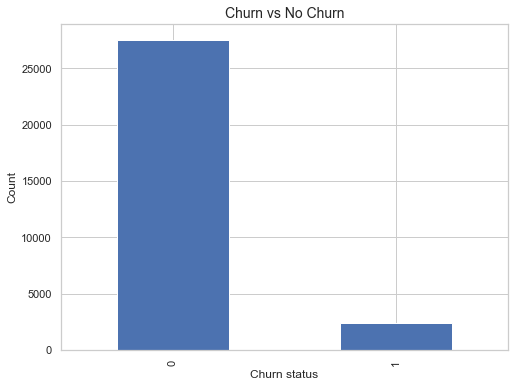

In [95]:
fig = plt.figure(figsize = (8,6))
high_value_customers['churn'].value_counts().plot(kind = 'bar')
plt.ylabel('Count')
plt.xlabel('Churn status')
plt.title('Churn vs No Churn',fontsize=14)

#### REMOVING THE FEATURES CORRESPONDING TO SEPTEMBER MONTH:

In [96]:
columns_9 = list(filter(lambda x: 1 if '_9' in x else 0, high_value_customers.columns))

In [97]:
columns_9 

['arpu_9',
 'onnet_mou_9',
 'offnet_mou_9',
 'roam_ic_mou_9',
 'roam_og_mou_9',
 'loc_og_t2t_mou_9',
 'loc_og_t2m_mou_9',
 'loc_og_t2f_mou_9',
 'loc_og_t2c_mou_9',
 'loc_og_mou_9',
 'std_og_t2t_mou_9',
 'std_og_t2m_mou_9',
 'std_og_t2f_mou_9',
 'std_og_t2c_mou_9',
 'std_og_mou_9',
 'isd_og_mou_9',
 'spl_og_mou_9',
 'og_others_9',
 'total_og_mou_9',
 'loc_ic_t2t_mou_9',
 'loc_ic_t2m_mou_9',
 'loc_ic_t2f_mou_9',
 'loc_ic_mou_9',
 'std_ic_t2t_mou_9',
 'std_ic_t2m_mou_9',
 'std_ic_t2f_mou_9',
 'std_ic_t2o_mou_9',
 'std_ic_mou_9',
 'total_ic_mou_9',
 'spl_ic_mou_9',
 'isd_ic_mou_9',
 'ic_others_9',
 'total_rech_num_9',
 'total_rech_amt_9',
 'max_rech_amt_9',
 'last_day_rch_amt_9',
 'total_rech_data_9',
 'max_rech_data_9',
 'count_rech_2g_9',
 'count_rech_3g_9',
 'av_rech_amt_data_9',
 'vol_2g_mb_9',
 'vol_3g_mb_9',
 'arpu_3g_9',
 'arpu_2g_9',
 'night_pck_user_9',
 'monthly_2g_9',
 'sachet_2g_9',
 'monthly_3g_9',
 'sachet_3g_9',
 'fb_user_9',
 'vbc_3g_9']

In [98]:
high_value_customers = high_value_customers.drop(columns = columns_9)

In [99]:
high_value_customers.shape

(30001, 170)

#### FEATURES WITH ONLY SINGLE UNIQUE VALUE:

In [100]:
unique_value = high_value_customers.nunique()
unique_cols = list(unique_value[unique_value == 1].index)
unique_cols

['circle_id',
 'loc_og_t2o_mou',
 'std_og_t2o_mou',
 'loc_ic_t2o_mou',
 'std_og_t2c_mou_6',
 'std_og_t2c_mou_7',
 'std_og_t2c_mou_8',
 'std_ic_t2o_mou_6',
 'std_ic_t2o_mou_7',
 'std_ic_t2o_mou_8']

Since all the above columns has only one unique value, we can remove all these column from learning.

In [101]:
high_value_customers = high_value_customers.drop(columns = unique_cols)

Quickly check what all categorical column we have anything with more than 5 unique value we will consider numerical

In [102]:
cat_columns = high_value_customers.nunique()
cat_columns = list(unique_value[unique_value < 5].index)
cat_columns

['circle_id',
 'loc_og_t2o_mou',
 'std_og_t2o_mou',
 'loc_ic_t2o_mou',
 'std_og_t2c_mou_6',
 'std_og_t2c_mou_7',
 'std_og_t2c_mou_8',
 'std_ic_t2o_mou_6',
 'std_ic_t2o_mou_7',
 'std_ic_t2o_mou_8',
 'night_pck_user_6',
 'night_pck_user_7',
 'night_pck_user_8',
 'fb_user_6',
 'fb_user_7',
 'fb_user_8',
 'churn']

#### 1.  mobile_number

In [103]:
if (high_value_customers['mobile_number'].nunique() == len(high_value_customers)):
    print("Each mobile number in this data set is unique")
else:
    print("Mobile number in this data set is not unique")

Each mobile number in this data set is unique


Mobile number is not going to give any info for the model hence we can remove this column for learning purpose

In [104]:
high_value_customers = high_value_customers.drop(columns = ['mobile_number'])

#### 2. arpu


 Univariate analysis for attribute arpu_6
         count   mean    std      min    25%    50%    75%      max
churn                                                              
0     27560.00 549.22 446.85 -2258.71 307.81 476.03 686.46 27731.09
1      2441.00 663.16 584.54  -209.47 336.89 556.66 834.24 11505.51

 Univariate analysis for attribute arpu_7
         count   mean    std      min    25%    50%    75%      max
churn                                                              
0     27560.00 562.61 474.01 -2014.05 315.59 482.76 697.69 35145.83
1      2441.00 540.17 540.37  -158.96 221.16 462.40 707.56 13224.12

 Univariate analysis for attribute arpu_8
         count   mean    std     min    25%    50%    75%      max
churn                                                             
0     27560.00 532.64 503.94 -945.81 260.81 447.09 678.84 33543.62
1      2441.00 237.20 386.44  -37.89   0.00  78.36 335.96  5228.83


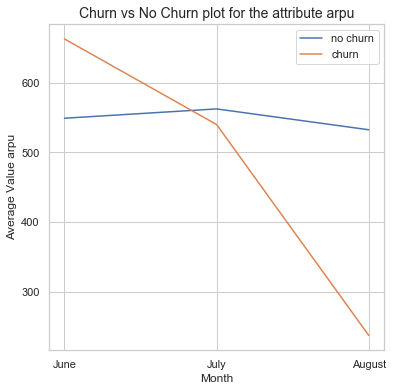

In [105]:
create_univariate_analysis(high_value_customers, 'arpu')

**Observation** - It is clear that mean ARPU value for the CHURN group drops month over month. Where as for Non Churn group this data is almost linear

#### 3. onnet_mou


 Univariate analysis for attribute onnet_mou_6
         count   mean    std  min   25%    50%    75%     max
churn                                                        
0     27560.00 251.20 442.81 0.00 17.39  83.30 280.52 7376.71
1      2441.00 369.06 608.46 0.00 12.38 113.01 457.96 7011.11

 Univariate analysis for attribute onnet_mou_7
         count   mean    std  min   25%   50%    75%     max
churn                                                       
0     27560.00 265.64 474.16 0.00 17.03 83.78 288.39 8011.91
1      2441.00 292.41 541.02 0.00  5.39 71.43 326.93 8157.78

 Univariate analysis for attribute onnet_mou_8
         count   mean    std  min   25%   50%    75%      max
churn                                                        
0     27560.00 244.82 465.99 0.00 14.18 73.58 257.03 10752.56
1      2441.00 113.23 339.98 0.00  0.00  2.36  63.51  5193.66


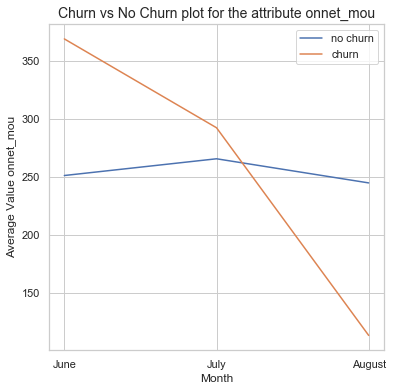

In [106]:
create_univariate_analysis(high_value_customers, 'onnet_mou')

**Observation** -It is clear that mean onnet_mou value for the CHURN group drops month over month. Where as for Non Churn group this data is almost constant. Hence this is a good indicator for Churn Vs No Churn.

#### 4. offnet_mou


 Univariate analysis for attribute offnet_mou_6
         count   mean    std  min   25%    50%    75%     max
churn                                                        
0     27560.00 365.05 463.19 0.00 72.66 221.44 479.27 6962.46
1      2441.00 471.33 655.05 0.00 58.24 239.14 607.21 8362.36

 Univariate analysis for attribute offnet_mou_7
         count   mean    std  min   25%    50%    75%     max
churn                                                        
0     27560.00 377.81 489.36 0.00 73.53 224.82 494.81 9667.13
1      2441.00 381.42 596.47 0.00 30.24 162.19 475.53 6339.34

 Univariate analysis for attribute offnet_mou_8
         count   mean    std  min   25%    50%    75%      max
churn                                                         
0     27560.00 352.51 490.18 0.00 60.18 202.79 460.53 14007.34
1      2441.00 138.25 318.00 0.00  0.00  10.28 130.08  4167.74


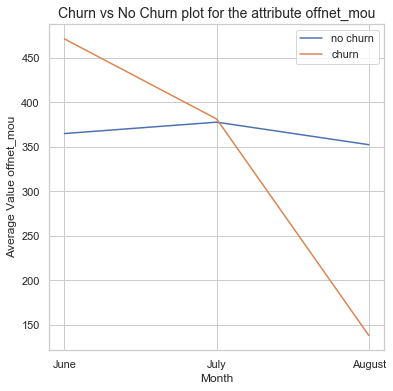

In [107]:
create_univariate_analysis(high_value_customers, 'offnet_mou')

**Observation** -It is clear that mean offnet_mou value for the CHURN group drops month over month. Where as for Non Churn group this data is almost constant. Hence this attribute is a good indicator for Churn Vs No Churn.

#### 5. roam_ic_mou


 Univariate analysis for attribute roam_ic_mou_6
         count  mean    std  min  25%  50%  75%     max
churn                                                  
0     27560.00 14.97  68.75 0.00 0.00 0.00 0.00 2613.31
1      2441.00 28.96 134.26 0.00 0.00 0.00 0.30 2307.91

 Univariate analysis for attribute roam_ic_mou_7
         count  mean    std  min  25%  50%  75%     max
churn                                                  
0     27560.00 11.11  66.49 0.00 0.00 0.00 0.00 2933.08
1      2441.00 29.96 142.68 0.00 0.00 0.00 4.63 3813.29

 Univariate analysis for attribute roam_ic_mou_8
         count  mean    std  min  25%  50%  75%     max
churn                                                  
0     27560.00 11.20  66.22 0.00 0.00 0.00 0.00 4169.81
1      2441.00 27.24 133.40 0.00 0.00 0.00 6.43 2898.34


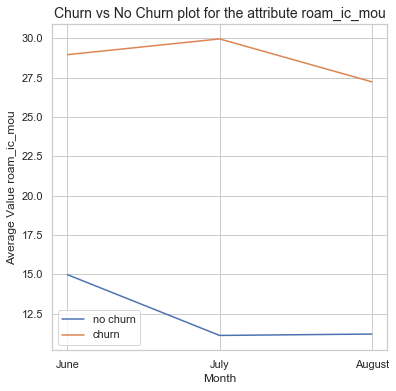

In [108]:
create_univariate_analysis(high_value_customers, 'roam_ic_mou')

**Observation** -We can observe that roam_ic_mou also decreases rapidly for churn group over the months.

#### 6. roam_og_mou


 Univariate analysis for attribute roam_og_mou_6
         count  mean    std  min  25%  50%  75%     max
churn                                                  
0     27560.00 24.34 105.61 0.00 0.00 0.00 0.00 3775.11
1      2441.00 51.80 198.38 0.00 0.00 0.00 0.94 3161.79

 Univariate analysis for attribute roam_og_mou_7
         count  mean    std  min  25%  50%   75%     max
churn                                                   
0     27560.00 17.50  86.34 0.00 0.00 0.00  0.00 1878.86
1      2441.00 50.13 168.44 0.00 0.00 0.00 18.73 2812.04

 Univariate analysis for attribute roam_og_mou_8
         count  mean    std  min  25%  50%   75%     max
churn                                                   
0     27560.00 17.76  95.31 0.00 0.00 0.00  0.00 3493.36
1      2441.00 43.64 177.78 0.00 0.00 0.00 17.76 5337.04


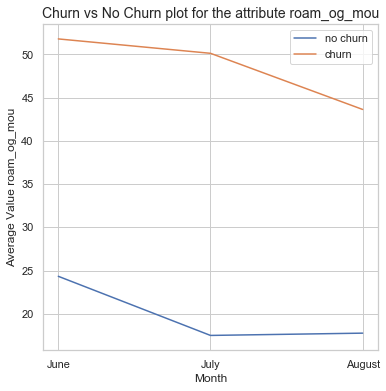

In [109]:
create_univariate_analysis(high_value_customers, 'roam_og_mou')

**Observation** -We can observe that roam_og_mou also decreases rapidly for churn group over the months.

#### 7. loc_og_mou


 Univariate analysis for attribute loc_og_mou_6
         count   mean    std  min   25%    50%    75%      max
churn                                                         
0     27560.00 260.99 382.44 0.00 35.08 131.32 342.15 10643.38
1      2441.00 176.06 318.34 0.00 11.08  64.48 210.78  3650.73

 Univariate analysis for attribute loc_og_mou_7
         count   mean    std  min   25%    50%    75%     max
churn                                                        
0     27560.00 265.64 381.60 0.00 38.91 138.04 348.22 7674.78
1      2441.00 136.32 269.84 0.00  2.59  45.16 150.54 3604.84

 Univariate analysis for attribute loc_og_mou_8
         count   mean    std  min   25%    50%    75%      max
churn                                                         
0     27560.00 252.23 372.21 0.00 32.38 128.38 330.60 11039.91
1      2441.00  49.42 144.31 0.00  0.00   0.00  31.16  3071.26


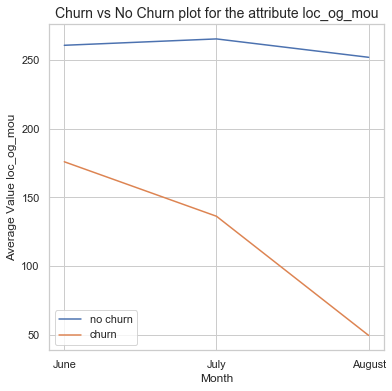

In [110]:
create_univariate_analysis(high_value_customers, 'loc_og_mou')

**Observation** - It is clear that for churn group the loacl outgoing call volume drops over the time period.

#### 8. std_og_mou


 Univariate analysis for attribute std_og_mou_6
         count   mean    std  min  25%    50%    75%     max
churn                                                       
0     27560.00 324.44 577.00 0.00 0.36  39.70 425.00 7498.03
1      2441.00 603.29 850.10 0.00 0.93 227.18 957.24 8432.99

 Univariate analysis for attribute std_og_mou_7
         count   mean    std  min  25%   50%    75%      max
churn                                                       
0     27560.00 353.66 626.21 0.00 0.25 42.08 476.45 10936.73
1      2441.00 480.55 767.46 0.00 0.00 96.04 727.73  8155.53

 Univariate analysis for attribute std_og_mou_8
         count   mean    std  min  25%   50%    75%      max
churn                                                       
0     27560.00 320.80 620.99 0.00 0.00 32.18 384.59 13980.06
1      2441.00 155.85 423.23 0.00 0.00  0.00  57.58  5129.38


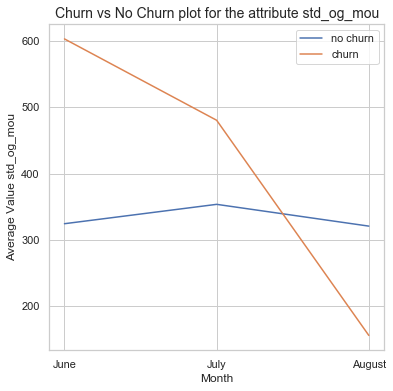

In [111]:
create_univariate_analysis(high_value_customers, 'std_og_mou')

**Observation** - It is clear that for churn group the STD outgoing call volume drops over the time period.

#### 9. isd_og_mou


 Univariate analysis for attribute isd_og_mou_6
         count  mean   std  min  25%  50%  75%     max
churn                                                 
0     27560.00  1.98 46.09 0.00 0.00 0.00 0.00 5900.66
1      2441.00  4.34 42.99 0.00 0.00 0.00 0.00 1233.43

 Univariate analysis for attribute isd_og_mou_7
         count  mean   std  min  25%  50%  75%     max
churn                                                 
0     27560.00  2.02 46.30 0.00 0.00 0.00 0.00 5490.28
1      2441.00  3.13 35.88 0.00 0.00 0.00 0.00 1049.89

 Univariate analysis for attribute isd_og_mou_8
         count  mean   std  min  25%  50%  75%     max
churn                                                 
0     27560.00  2.01 46.34 0.00 0.00 0.00 0.00 5681.54
1      2441.00  1.24 18.07 0.00 0.00 0.00 0.00  555.71


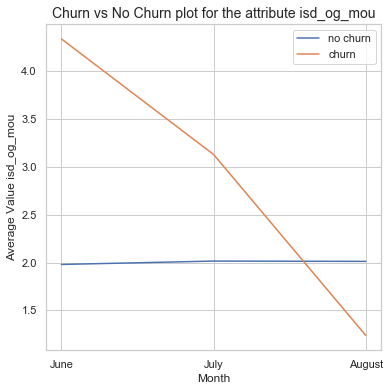

In [112]:
create_univariate_analysis(high_value_customers, 'isd_og_mou')

**Observation** - It is clear that for churn group the ISD outgoing call volume drops over the time period.

#### 10. total_og_mou


 Univariate analysis for attribute total_og_mou_6
         count   mean    std  min    25%    50%     75%      max
churn                                                           
0     27560.00 593.76 666.58 0.00 118.35 403.78  835.72 10674.03
1      2441.00 791.68 902.20 0.00  81.31 531.16 1188.58  8488.36

 Univariate analysis for attribute total_og_mou_7
         count   mean    std  min    25%    50%    75%      max
churn                                                          
0     27560.00 628.44 706.78 0.00 125.95 431.41 889.94 11365.31
1      2441.00 627.51 826.17 0.00  18.03 334.63 912.89  8285.64

 Univariate analysis for attribute total_og_mou_8
         count   mean    std  min    25%    50%    75%      max
churn                                                          
0     27560.00 582.00 708.98 0.00 101.97 367.74 807.71 14043.06
1      2441.00 209.36 477.37 0.00   0.00   0.00 191.71  5206.21


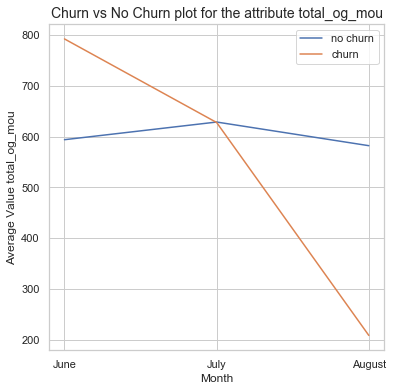

In [113]:
create_univariate_analysis(high_value_customers, 'total_og_mou')

**Observation** - It is clear that for churn group the Total outgoing call volume drops over the time period.

#### 11. loc_ic_mou


 Univariate analysis for attribute loc_ic_mou_6
         count   mean    std  min   25%    50%    75%     max
churn                                                        
0     27560.00 237.05 316.22 0.00 51.16 140.69 305.71 7454.63
1      2441.00 164.61 290.46 0.00 18.93  78.21 194.61 5085.63

 Univariate analysis for attribute loc_ic_mou_7
         count   mean    std  min   25%    50%    75%     max
churn                                                        
0     27560.00 243.72 320.61 0.00 58.71 146.44 311.51 6466.74
1      2441.00 128.03 233.32 0.00  6.68  56.98 149.21 2909.53

 Univariate analysis for attribute loc_ic_mou_8
         count   mean    std  min   25%    50%    75%     max
churn                                                        
0     27560.00 239.08 315.17 0.00 53.08 143.53 303.43 5388.74
1      2441.00  44.67 110.02 0.00  0.00   0.00  38.56 1654.51


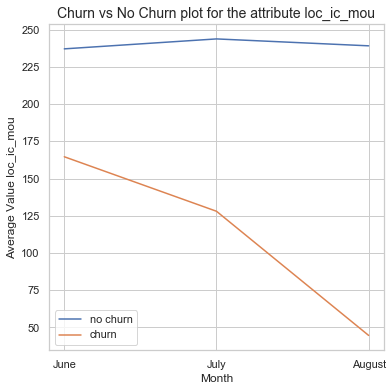

In [114]:
create_univariate_analysis(high_value_customers, 'loc_ic_mou')

**Observation** - Similar to outgoing call trend, incoming local call volume also drops over given period for the churn group

#### 12. std_ic_mou


 Univariate analysis for attribute std_ic_mou_6
         count  mean    std  min  25%   50%   75%     max
churn                                                    
0     27560.00 46.15 136.47 0.00 1.06 11.23 40.91 5459.63
1      2441.00 54.06 148.45 0.00 0.66 14.16 48.31 2815.03

 Univariate analysis for attribute std_ic_mou_7
         count  mean    std  min  25%   50%   75%     max
churn                                                    
0     27560.00 49.52 147.87 0.00 1.19 12.41 44.43 6745.76
1      2441.00 43.73 151.33 0.00 0.00  8.26 35.73 3470.38

 Univariate analysis for attribute std_ic_mou_8
         count  mean    std  min  25%   50%   75%     max
churn                                                    
0     27560.00 47.06 143.19 0.00 0.93 10.93 41.25 5957.14
1      2441.00 14.44  66.10 0.00 0.00  0.00  4.90 1629.76


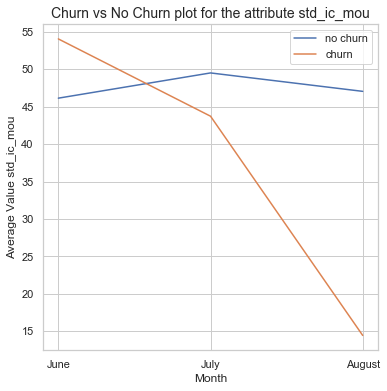

In [115]:
create_univariate_analysis(high_value_customers, 'std_ic_mou')

**Observation** - Similar to outgoing call trend, incoming STD call volume also drops over given period for the churn group

#### 13. isd_ic_mou


 Univariate analysis for attribute isd_ic_mou_6
         count  mean   std  min  25%  50%  75%     max
churn                                                 
0     27560.00 10.69 78.44 0.00 0.00 0.00 0.00 6789.41
1      2441.00 11.80 53.71 0.00 0.00 0.00 0.00  840.56

 Univariate analysis for attribute isd_ic_mou_7
         count  mean   std  min  25%  50%  75%     max
churn                                                 
0     27560.00 12.02 81.95 0.00 0.00 0.00 0.00 4747.91
1      2441.00 10.28 56.51 0.00 0.00 0.00 0.00 1592.24

 Univariate analysis for attribute isd_ic_mou_8
         count  mean   std  min  25%  50%  75%     max
churn                                                 
0     27560.00 11.63 73.09 0.00 0.00 0.00 0.00 3432.88
1      2441.00  3.92 29.93 0.00 0.00 0.00 0.00  958.98


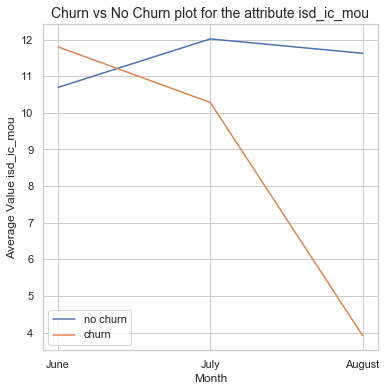

In [116]:
create_univariate_analysis(high_value_customers, 'isd_ic_mou')

**Observation** - The ISD incoming call volume also low over the period for the churn group

#### 14. total_ic_mou


 Univariate analysis for attribute total_ic_mou_6
         count   mean    std  min   25%    50%    75%     max
churn                                                        
0     27560.00 295.13 366.93 0.00 76.61 188.75 378.91 7716.14
1      2441.00 231.45 343.93 0.00 36.74 128.36 284.86 5085.63

 Univariate analysis for attribute total_ic_mou_7
         count   mean    std  min   25%    50%    75%     max
churn                                                        
0     27560.00 306.84 377.81 0.00 86.16 196.73 389.29 7442.86
1      2441.00 182.91 301.89 0.00 14.66  88.54 227.34 3470.38

 Univariate analysis for attribute total_ic_mou_8
         count   mean    std  min   25%    50%    75%     max
churn                                                        
0     27560.00 299.10 368.22 0.00 78.63 191.93 381.86 6066.63
1      2441.00  63.44 146.47 0.00  0.00   0.00  58.88 1750.36


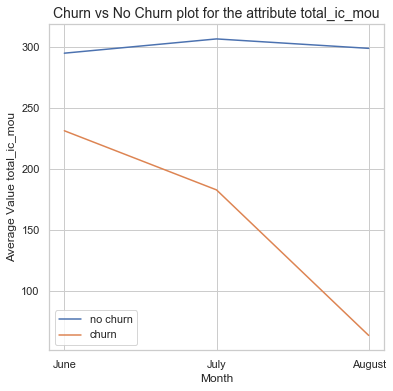

In [117]:
create_univariate_analysis(high_value_customers, 'total_ic_mou')

**Observation** - The total incoming call volume also low over the period for the churn group

#### 15. total_rech_num


 Univariate analysis for attribute total_rech_num_6
         count  mean   std  min  25%   50%   75%    max
churn                                                  
0     27560.00 11.67  9.19 0.00 6.00  9.00 14.00 307.00
1      2441.00 13.90 11.59 0.00 7.00 11.00 17.00 125.00

 Univariate analysis for attribute total_rech_num_7
         count  mean   std  min  25%  50%   75%    max
churn                                                 
0     27560.00 11.75  9.33 0.00 6.00 9.00 15.00 138.00
1      2441.00 11.40 10.50 0.00 5.00 9.00 15.00 110.00

 Univariate analysis for attribute total_rech_num_8
         count  mean  std  min  25%  50%   75%    max
churn                                                
0     27560.00 10.39 9.31 0.00 4.00 8.00 13.00 138.00
1      2441.00  5.24 7.34 0.00 2.00 3.00  6.00 196.00


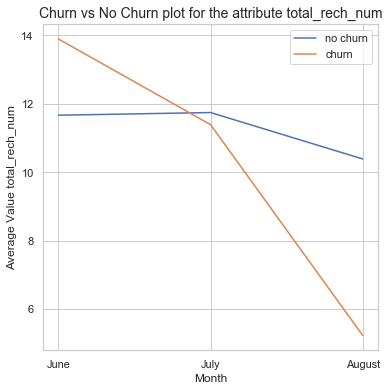

In [118]:
create_univariate_analysis(high_value_customers, 'total_rech_num')

**Observation** - Total number of recharge also rapidly decreases for the churn group over the given period of time.

#### 16 . total_rech_amt


 Univariate analysis for attribute total_rech_amt_6
         count   mean    std  min    25%    50%     75%      max
churn                                                           
0     27560.00 649.57 547.70 0.00 358.00 558.00  816.25 35190.00
1      2441.00 786.71 681.56 0.00 406.00 660.00 1002.00 12000.00

 Univariate analysis for attribute total_rech_amt_7
         count   mean    std  min    25%    50%    75%      max
churn                                                          
0     27560.00 663.53 574.16 0.00 360.00 565.00 830.00 40335.00
1      2441.00 626.29 667.94 0.00 242.00 526.00 847.00 16984.00

 Univariate analysis for attribute total_rech_amt_8
         count   mean    std  min    25%    50%    75%      max
churn                                                          
0     27560.00 613.70 614.83 0.00 280.00 510.00 797.00 45320.00
1      2441.00 253.15 452.36 0.00   0.00  45.00 350.00  6544.00


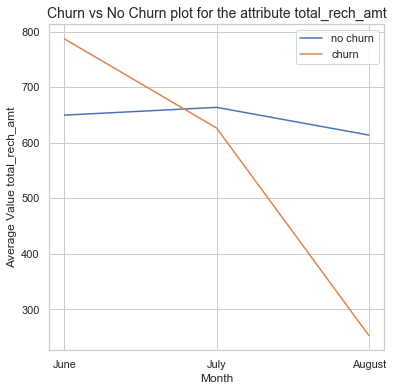

In [119]:
create_univariate_analysis(high_value_customers, 'total_rech_amt')

**Observation** - Like all other attribute we have seen so far,  total_rech_amt for churn group also reduces over the period.

#### 17. max_rech_amt


 Univariate analysis for attribute max_rech_amt_6
         count   mean    std  min    25%    50%    75%     max
churn                                                         
0     27560.00 169.05 172.00 0.00 110.00 120.00 200.00 4010.00
1      2441.00 171.94 209.12 0.00  90.00 110.00 198.00 2933.00

 Univariate analysis for attribute max_rech_amt_7
         count   mean    std  min    25%    50%    75%     max
churn                                                         
0     27560.00 173.34 176.75 0.00 110.00 130.00 200.00 4010.00
1      2441.00 159.39 226.97 0.00  50.00 110.00 154.00 2933.00

 Univariate analysis for attribute max_rech_amt_8
         count   mean    std  min   25%    50%    75%     max
churn                                                        
0     27560.00 166.77 171.34 0.00 67.00 144.00 198.00 4449.00
1      2441.00  85.37 176.65 0.00  0.00  30.00 130.00 3100.00


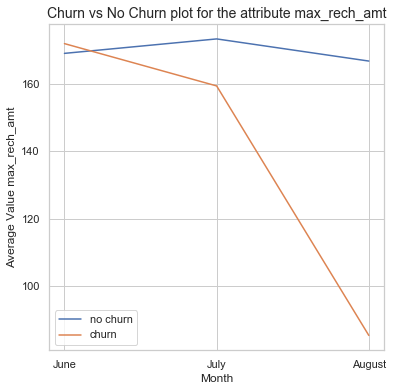

In [120]:
create_univariate_analysis(high_value_customers, 'max_rech_amt')

**Observation** - max_rech_amnt also follows the same trend as other variables we have seen so far.

#### 18. total_rech_data


 Univariate analysis for attribute total_rech_data_6
         count  mean  std  min  25%  50%  75%   max
churn                                              
0     27560.00  1.68 2.82 0.00 0.00 1.00 2.00 61.00
1      2441.00  1.56 2.92 0.00 0.00 0.00 2.00 34.00

 Univariate analysis for attribute total_rech_data_7
         count  mean  std  min  25%  50%  75%   max
churn                                              
0     27560.00  1.90 3.11 0.00 0.00 1.00 2.00 54.00
1      2441.00  1.31 2.86 0.00 0.00 0.00 1.00 43.00

 Univariate analysis for attribute total_rech_data_8
         count  mean  std  min  25%  50%  75%   max
churn                                              
0     27560.00  1.73 3.07 0.00 0.00 1.00 2.00 60.00
1      2441.00  0.41 1.41 0.00 0.00 0.00 0.00 32.00


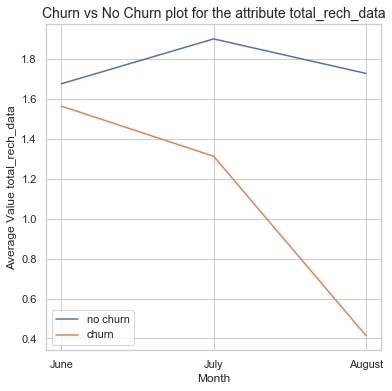

In [121]:
create_univariate_analysis(high_value_customers, 'total_rech_data')

**Observation** - Data package is also following same trend as call. The total_rech_data also decreases over time for churn group.

#### 19. max_rech_data


 Univariate analysis for attribute max_rech_data_6
         count  mean    std  min  25%   50%    75%     max
churn                                                     
0     27560.00 79.20 111.48 0.00 0.00 25.00 154.00 1555.00
1      2441.00 65.38 125.31 0.00 0.00  0.00  98.00 1555.00

 Univariate analysis for attribute max_rech_data_7
         count  mean    std  min  25%   50%    75%     max
churn                                                     
0     27560.00 82.19 113.31 0.00 0.00 25.00 154.00 1555.00
1      2441.00 53.35 121.52 0.00 0.00  0.00  41.00 1555.00

 Univariate analysis for attribute max_rech_data_8
         count  mean    std  min  25%   50%    75%     max
churn                                                     
0     27560.00 76.95 111.54 0.00 0.00 23.00 154.00 1555.00
1      2441.00 22.14  83.85 0.00 0.00  0.00   0.00 1555.00


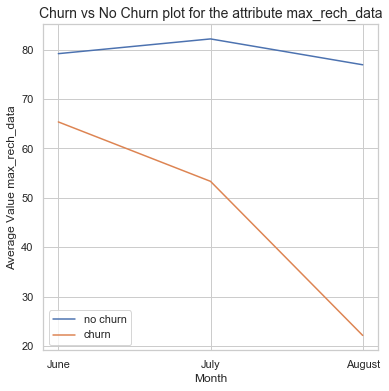

In [122]:
create_univariate_analysis(high_value_customers, 'max_rech_data')

**Observation** - Data package is also following same trend as call. The max_rech_data also decreases over time for churn group.

#### 20. av_rech_amt_data


 Univariate analysis for attribute av_rech_amt_data_6
         count   mean    std  min  25%   50%    75%     max
churn                                                      
0     27560.00 132.48 201.15 0.00 0.00 50.00 198.00 7546.00
1      2441.00 110.03 189.62 0.00 0.00  0.00 173.00 1796.00

 Univariate analysis for attribute av_rech_amt_data_7
         count   mean    std  min  25%   50%    75%     max
churn                                                      
0     27560.00 144.23 208.00 0.00 0.00 92.00 225.00 4365.00
1      2441.00  89.58 185.65 0.00 0.00  0.00 137.00 2410.00

 Univariate analysis for attribute av_rech_amt_data_8
         count   mean    std  min  25%   50%    75%     max
churn                                                      
0     27560.00 130.13 198.94 0.00 0.00 46.00 198.00 4061.00
1      2441.00  31.79 120.15 0.00 0.00  0.00   0.00 2261.00


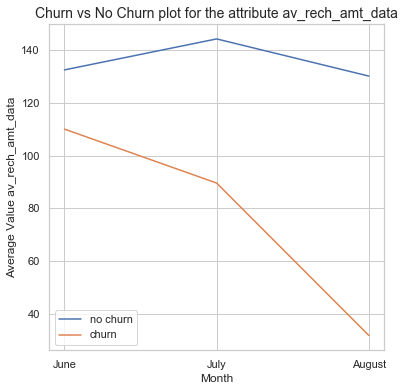

In [123]:
create_univariate_analysis(high_value_customers, 'av_rech_amt_data')

#### 21. vol_2g_mb


 Univariate analysis for attribute vol_2g_mb_6
         count   mean    std  min  25%  50%   75%      max
churn                                                     
0     27560.00 127.83 332.57 0.00 0.00 0.10 86.61 10285.90
1      2441.00 111.75 306.19 0.00 0.00 0.00 47.33  4017.16

 Univariate analysis for attribute vol_2g_mb_7
         count   mean    std  min  25%  50%   75%     max
churn                                                    
0     27560.00 128.23 334.31 0.00 0.00 0.52 83.88 7873.55
1      2441.00  89.74 296.34 0.00 0.00 0.00 14.90 4460.12

 Univariate analysis for attribute vol_2g_mb_8
         count   mean    std  min  25%  50%   75%      max
churn                                                     
0     27560.00 113.24 323.29 0.00 0.00 0.00 62.87 11117.61
1      2441.00  23.15 139.85 0.00 0.00 0.00  0.00  3349.19


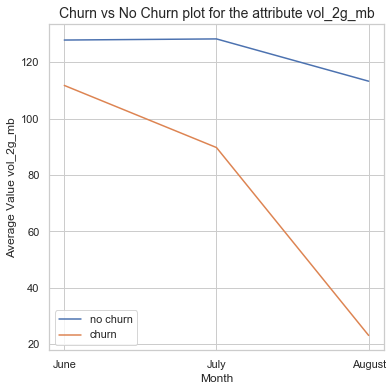

In [124]:
create_univariate_analysis(high_value_customers, 'vol_2g_mb')

#### 22. vol_3g_mb 


 Univariate analysis for attribute vol_3g_mb_6
         count   mean    std  min  25%  50%    75%      max
churn                                                      
0     27560.00 349.83 923.22 0.00 0.00 0.00 379.05 45735.40
1      2441.00 281.41 796.49 0.00 0.00 0.00  61.08  9400.12

 Univariate analysis for attribute vol_3g_mb_7
         count   mean    std  min  25%  50%    75%      max
churn                                                      
0     27560.00 383.55 927.17 0.00 0.00 0.00 447.30 28144.12
1      2441.00 219.45 755.88 0.00 0.00 0.00   0.00 15115.51

 Univariate analysis for attribute vol_3g_mb_8
         count   mean    std  min  25%  50%    75%      max
churn                                                      
0     27560.00 374.88 943.08 0.00 0.00 0.00 420.30 30036.06
1      2441.00  87.40 512.73 0.00 0.00 0.00   0.00 13440.72


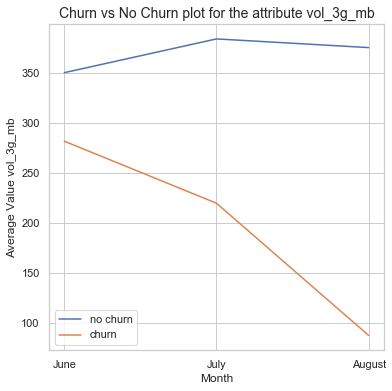

In [125]:
create_univariate_analysis(high_value_customers, 'vol_3g_mb')

#### 23. arpu_2g


 Univariate analysis for attribute arpu_2g_6
         count  mean    std    min  25%  50%   75%     max
churn                                                     
0     27560.00 63.44 161.21 -15.32 0.00 0.00 53.21 6433.76
1      2441.00 63.41 158.78  -2.33 0.00 0.00 29.00 1594.44

 Univariate analysis for attribute arpu_2g_7
         count  mean    std    min  25%  50%   75%     max
churn                                                     
0     27560.00 66.13 166.81 -15.48 0.00 0.00 55.38 4809.36
1      2441.00 48.60 146.01  -0.18 0.00 0.00  3.74 2057.60

 Univariate analysis for attribute arpu_2g_8
         count  mean    std    min  25%  50%   75%     max
churn                                                     
0     27560.00 62.00 156.43 -24.43 0.00 0.00 37.48 3467.17
1      2441.00 17.68  90.66  -2.08 0.00 0.00  0.00 1930.37


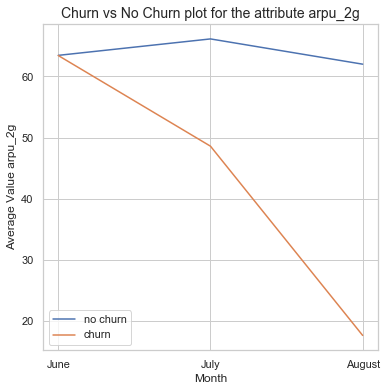

In [126]:
create_univariate_analysis(high_value_customers, 'arpu_2g')

#### 24. arpu_3g


 Univariate analysis for attribute arpu_3g_6
         count  mean    std    min  25%  50%   75%     max
churn                                                     
0     27560.00 67.13 178.79 -30.28 0.00 0.00 37.14 6362.28
1      2441.00 65.63 183.29  -9.55 0.00 0.00 10.91 2882.55

 Univariate analysis for attribute arpu_3g_7
         count  mean    std    min  25%  50%   75%     max
churn                                                     
0     27560.00 70.30 185.37 -26.04 0.00 0.00 42.39 4980.90
1      2441.00 49.69 154.39  -0.58 0.00 0.00  0.00 2057.61

 Univariate analysis for attribute arpu_3g_8
         count  mean    std    min  25%  50%   75%     max
churn                                                     
0     27560.00 66.73 174.85 -24.49 0.00 0.00 29.72 3716.90
1      2441.00 18.07  92.53   0.00 0.00 0.00  0.00 1930.39


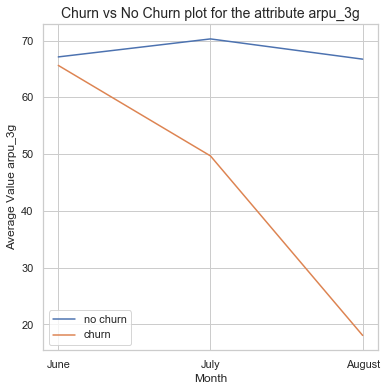

In [127]:
create_univariate_analysis(high_value_customers, 'arpu_3g')

#### 25. aon

Univariate analysis for attribute aon
         count    mean    std    min    25%    50%     75%     max
churn                                                             
0     27560.00 1240.23 968.15 180.00 471.00 880.00 1839.25 4321.00
1      2441.00  860.95 746.63 180.00 356.00 602.00 1039.00 3670.00


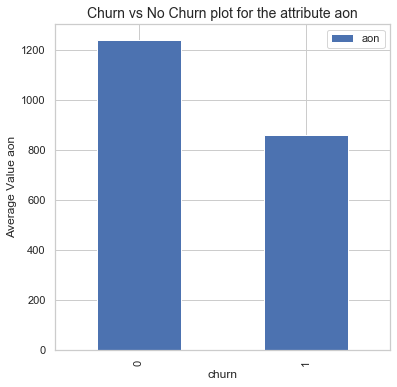

In [128]:
create_univariate_analysis(high_value_customers, 'aon')

**Observation** - The non churners are more loyal customers and they have been with the same network for a large period of time cumpared to churn group.

From above Plots it is clear that almost all the attributes see a drastic reduction for the churn group over the period of time.

**DERIVE NEW FEATURES**

Now let us derive some feature. We will compute the difference between August month data and average of the good phase [(July + June)/2]  data for some of the important attributes, which will explain how much reduction is there in these data, for churn group when compared to non churn group. Higher the value of these data are good indicators for predicting the churn:

1. total_ic_mou
2. total_og_mou
3. total_rech_amnt
4. av_rech_amt_data

In [129]:
high_value_customers['total_ic_mou_delta'] = ((high_value_customers.total_ic_mou_6 + high_value_customers.total_ic_mou_7)/2) - high_value_customers.total_ic_mou_8
high_value_customers['total_og_mou_delta'] = ((high_value_customers.total_og_mou_6 + high_value_customers.total_og_mou_7)/2) - high_value_customers.total_og_mou_8
high_value_customers['total_rech_amt_delta'] = ((high_value_customers.total_rech_amt_6 + high_value_customers.total_rech_amt_7)/2) - high_value_customers.total_rech_amt_8
high_value_customers['av_rech_amt_data_delta'] = ((high_value_customers.av_rech_amt_data_6 + high_value_customers.av_rech_amt_data_7)/2) - high_value_customers.av_rech_amt_data_8

In [130]:
high_value_customers.shape

(30001, 163)

In [131]:
nullvals = (high_value_customers.isnull().sum()/len(high_value_customers))*100
nullvals = list(nullvals[nullvals != 0].index)

In [132]:
nullvals

[]

### OUTLIER TREATMENT

As we can see from the above univariate analysis all the numeric attributes suffers from outliers. Let us do capping between 1percentile and 99 percentile, as the data set is highly imbalanced and outliers might be able to give more insights.

In [133]:
all_columns = list(high_value_customers.columns)

In [134]:
categories = ['night_pck_user_6', 'night_pck_user_7','night_pck_user_8', 'fb_user_6', 'fb_user_7','fb_user_8', 'churn']
numeric_columns = list(set(all_columns) - set(categories))
print(numeric_columns)

['spl_ic_mou_8', 'offnet_mou_7', 'roam_og_mou_7', 'last_day_rch_amt_6', 'monthly_3g_7', 'count_rech_3g_8', 'std_og_t2m_mou_7', 'arpu_8', 'avg_amount_rech_6_7', 'ic_others_7', 'total_og_mou_delta', 'std_og_t2m_mou_6', 'total_rech_data_7', 'roam_og_mou_8', 'isd_og_mou_6', 'std_ic_t2t_mou_7', 'loc_ic_mou_7', 'std_ic_t2t_mou_8', 'spl_ic_mou_6', 'og_others_7', 'count_rech_3g_7', 'std_og_t2t_mou_6', 'max_rech_amt_8', 'ic_others_6', 'total_amount_rech_7', 'loc_og_t2t_mou_6', 'arpu_2g_8', 'monthly_2g_7', 'monthly_3g_6', 'loc_ic_t2f_mou_8', 'loc_og_t2c_mou_8', 'spl_og_mou_7', 'std_ic_t2t_mou_6', 'total_data_rech_amnt_8', 'loc_og_t2c_mou_6', 'loc_ic_t2f_mou_7', 'spl_ic_mou_7', 'total_rech_num_7', 'og_others_8', 'av_rech_amt_data_6', 'arpu_2g_6', 'std_og_mou_6', 'vol_3g_mb_7', 'std_ic_t2m_mou_6', 'loc_og_t2f_mou_7', 'vol_2g_mb_8', 'std_og_mou_8', 'total_rech_amt_7', 'loc_ic_mou_8', 'roam_og_mou_6', 'count_rech_3g_6', 'vol_3g_mb_8', 'loc_og_t2f_mou_8', 'arpu_2g_7', 'loc_og_mou_8', 'isd_ic_mou_7', 

In [135]:
for col in numeric_columns:
    percentiles = high_value_customers[col].quantile([0.01,0.99]).values
    high_value_customers[col][high_value_customers[col] <= percentiles[0]] = percentiles[0]
    high_value_customers[col][high_value_customers[col] >= percentiles[1]] = percentiles[1]

In [136]:
print("Non Churn: ", (len(high_value_customers[high_value_customers.churn == 0])))
print("Churn: ", (len(high_value_customers[high_value_customers.churn == 1])))

Non Churn:  27560
Churn:  2441


In [137]:
print("% Non Churn: ", (len(high_value_customers[high_value_customers.churn == 0])/len(high_value_customers))*100)
print("% Churn: ", (len(high_value_customers[high_value_customers.churn == 1])/len(high_value_customers))*100)

% Non Churn:  91.86360454651512
% Churn:  8.136395453484884


In [138]:
high_value_customers_original = high_value_customers.copy()

## MODEL EVALUATION:

In [139]:
pd.options.display.float_format = '{:.6f}'.format

Below method will be used to calculate sensitvity, specificity and ROC etc

In [140]:
def calculate_metrics(y_actual, y_pred):
    confusion = metrics.confusion_matrix(y_actual, y_pred)
    print("Confusion Matrix: ")
    print(confusion)

    TP = confusion[1,1] # true positive 
    TN = confusion[0,0] # true negatives
    FP = confusion[0,1] # false positives
    FN = confusion[1,0] # false negatives
    
    print("Sensitivity: ",  round((TP / float(TP+FN)), 4))
    print("Specificity: ",  round((TN / float(TN+FP)), 4))
    print("Precision/Positive Predictive Rate: ", round((TP / float(TP+FP)), 4))
    print("Negative Predictive Rate: ", round((TN / float(TN+ FN)), 4))   

Below **draw_roc** implementation is taken from the worked out example for "TelecomChurnPrediction Case Study" as part of Module2: Machine Learning 1, Session 3: Logistic Regression.

In [141]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

The below implementation was part of "TelecomChurnPrediction Case Study" explained under Module2: Machine Learning 1, Session 3: Logistic Regression. We have converted it as a utility function as we need to use it more than once.

In [142]:
def plot_metrics(y_actual, y_pred_proba):  
    # Let's create columns with different probability cutoffs 
    y_train_pred_final = pd.DataFrame()
    y_train_pred_final["Prob"] = list(y_pred_proba[:,1])
    y_train_pred_final["churn"] = y_actual

    numbers = [float(x)/10 for x in range(10)]
    for i in numbers:
        y_train_pred_final[i]= y_train_pred_final["Prob"].map(lambda x: 1 if x > i else 0)
    y_train_pred_final.head()

    # Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
    cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
    from sklearn.metrics import confusion_matrix

    # TP = confusion[1,1] # true positive 
    # TN = confusion[0,0] # true negatives
    # FP = confusion[0,1] # false positives
    # FN = confusion[1,0] # false negatives

    num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    for i in num:
        cm1 = metrics.confusion_matrix(y_actual, y_train_pred_final[i] )
        total1=sum(sum(cm1))
        accuracy = (cm1[0,0]+cm1[1,1])/total1

        speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
        sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
        cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
    print(cutoff_df)

    # Let's plot accuracy sensitivity and specificity for various probabilities.
    cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
    plt.show()

### TRAIN TEST SPLIT:

As we have seen above the data is highly imbalanced. Approx 91.88% of the data belongs to "Non Churn" category and only 8.12% belongs to churn category. Since there is is high imbalance, special care needed while creating train test split. We may need to make sure both train and test split has original distribution.

To handle this, we will pass the **stratify** parameter while invoking **train_test_split**

In [143]:
y = high_value_customers.pop('churn')

In [144]:
X = high_value_customers

In [145]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.70, test_size=0.30, random_state=42, stratify = y)

In [146]:
print("% Non Churn in Training Data: ", (len(y_train[y_train == 0])/len(y_train))*100)
print("% Churn in Training Data: ", (len(y_train[y_train == 1])/len(y_train))*100)

% Non Churn in Training Data:  91.86190476190477
% Churn in Training Data:  8.13809523809524


In [147]:
print("Non Churn: ", (len(y_train[y_train == 0])))
print("Churn: ", (len(y_train[y_train == 1])))

Non Churn:  19291
Churn:  1709


In [148]:
print("% Non Churn in Test Data: ", (len(y_test[y_test == 0])/len(y_test))*100)
print("% Churn in Test Data: ", (len(y_test[y_test == 1])/len(y_test))*100)

% Non Churn in Test Data:  91.86757026997
% Churn in Test Data:  8.132429730029997


We can see that both train and test split has category distribution which is similar to original dataset.

In [149]:
# Lets perform the scaling using StandardScaler

StdScaler = StandardScaler()
X_train = StdScaler.fit_transform(X_train)
X_test = StdScaler.transform(X_test)

In [150]:
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# MODEL BUILDING FOR CHURN PREDICTION:

The models which are eveluated below are solely for predicting whether a high-value customer will churn or not, in near future (i.e. churn phase). 

### PCA TO REDUCE THE NUMBER OF ATTRIBUTES:

We need to first standardize the data before applying the PCA. As PCS expects the data to be centered and standardized.

In [151]:
# Lets perform PCA and derive how many principal compaonents we may have to use for model building

pca = PCA()
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [152]:
pca.components_

array([[-5.91448387e-02, -5.79802605e-02, -4.25363066e-02, ...,
        -2.62049031e-02, -2.33417219e-02,  1.23175090e-02],
       [ 1.36728520e-01,  1.50604675e-01,  1.60820222e-01, ...,
        -2.27476811e-02, -2.95136866e-02, -2.54522764e-02],
       [ 1.04161044e-01,  1.36294030e-01,  1.23004996e-01, ...,
        -9.53453182e-04, -1.53398142e-02, -2.70341667e-02],
       ...,
       [ 2.92157969e-04, -4.88077306e-04,  3.42038354e-04, ...,
         5.72095342e-05, -2.95790284e-04, -2.77935232e-04],
       [ 0.00000000e+00,  1.00288903e-16, -1.36224212e-17, ...,
        -4.25728778e-16,  1.22163977e-16, -1.63497822e-16],
       [-0.00000000e+00, -1.01543286e-16,  2.22548135e-16, ...,
        -2.72926754e-16, -8.15631696e-17,  1.86281684e-16]])

In [153]:
exp_variance = list(pca.explained_variance_ratio_.cumsum())
exp_variance.insert(0, 0)
exp_variance = [x*100 for x in exp_variance]

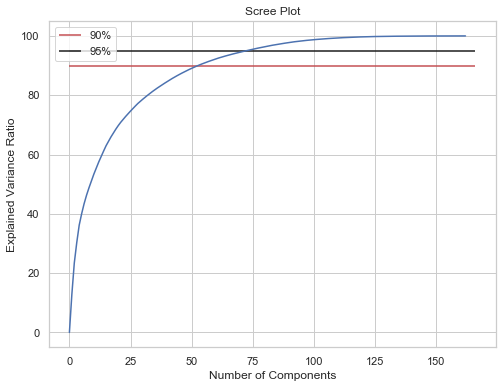

In [154]:
# Scree Plot
fif = plt.figure(figsize = (8, 6))
ax = plt.subplot(1,1,1)
plt.plot(range(len(exp_variance)), exp_variance)
plt.hlines(90, 0, 166, colors = 'r', label = '90%')
plt.hlines(95, 0, 166, colors = 'k', label = '95%')
plt.title("Scree Plot")
plt.ylabel("Explained Variance Ratio")
plt.xlabel("Number of Components")
ax.legend()
plt.show()

From the screeplot almost 55 components explain 90% variance and approximately 75 components explains 95% variance in the data. Since our data has high imbalance we will go with more conservative approach of selecting the components which explains 95% variance.

In [155]:
pca = PCA(0.95)

In [156]:
X_train = pca.fit_transform(X_train)
len(pca.components_)

73

In [157]:
X_test = pca.transform(X_test)

Before going through the model creation, let us see how we are going to tackle class imbalance in this data set. We will be following the below techniques:
    
a. By setting class weight for sklearn based Models.

b. Through over sampling the minority class. We will be using SMOTE package for this.

As per the problem statement the company has stated that the it will cost 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition. Also for many incumbent operators, retaining high profitable customers is the number one business goal.  Hence the Type 1 error (False Positive) is acceptable compared to to Type 2 error (False Negatives). Hence we will be trying to maximise the Recall/Sensitivity. As stated above given the cost to acquire new customers the companies cant afford loosing high value customers, hence Recall will have a higher weightage compared to precision. Due to same reason we are not maximising F1, but still we will be having a check on F1, so that will focus on a model which maximise Recall same time provides a decent F1 score.

Since the data is highly imbalanced the AUC_ROC will not perform well and it will provide a highly optimistic value. Hence AUC_ROC wont be considered for model evaluation. 
    

## A. MODELS WITH CLASS IMBALANCE TREATMENT BY APPLYING CLASS WEIGHT:

### A. 1. LOGISTIC REGRESSION WITH INVERSE WEIGHTAGE

First we will create a base model directly on the data without applying any class imbalance techniques or without tuning the hyper parameters.

In [158]:
logRegression = LogisticRegression( random_state = 42)

In [159]:
logRegression.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [160]:
y_pred = logRegression.predict(X_train);

In [161]:
calculate_metrics(y_train, y_pred)

Confusion Matrix: 
[[19046   245]
 [ 1165   544]]
Sensitivity:  0.3183
Specificity:  0.9873
Precision/Positive Predictive Rate:  0.6895
Negative Predictive Rate:  0.9424


In [162]:
y_pred_test = logRegression.predict(X_test)

In [163]:
calculate_metrics(y_test, y_pred_test)

Confusion Matrix: 
[[8174   95]
 [ 512  220]]
Sensitivity:  0.3005
Specificity:  0.9885
Precision/Positive Predictive Rate:  0.6984
Negative Predictive Rate:  0.9411


From above it is observed that only 30% of the churn its able to identify. But the company is looking to identify the churn as much as possible. Hence this model wont serve the purpose

**APPLY CLASS WEIGHT**

Let us apply the class_weight as balanced so it will take the inverse ratio for each class and apply it as the penalty. 

In [164]:

logRegressionCV = LogisticRegression(class_weight = 'balanced', random_state = 42)
params = {'C': [0.1, 0.2, 0.5, 1, 2, 3, 4, 5, 10], 'penalty': ['l1', 'l2']}
SKfolds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

# create gridsearch object
model = GridSearchCV(estimator=logRegressionCV, 
                     cv=SKfolds, 
                     param_grid=params, 
                     scoring=['f1', 'recall', 'roc_auc'], 
                     verbose=1,
                     refit = 'recall',
                     return_train_score=True)
model.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    9.5s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=42, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 0.2, 0.5, 1, 2, 3, 4, 5, 10],
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit='recall', return_train_score=True,
             scoring=['f1', 'recall', 'roc_auc'], verbose=1)

In [165]:
cv_result_log_reg = pd.DataFrame(model.cv_results_)
cv_result_log_reg = cv_result_log_reg[['param_C', 'param_penalty', 
                                       'mean_train_recall', 'mean_test_recall', 
                                       'mean_train_f1', 'mean_test_f1', 
                                       'mean_train_roc_auc', 'mean_test_roc_auc']]

**CV RESULT - BASED ON RECALL**

In [166]:
cv_result_log = cv_result_log_reg.sort_values(by =['mean_test_recall'], ascending = False )
cv_result_log.head(5)

,param_C,param_penalty,mean_train_recall,mean_test_recall,mean_train_f1,mean_test_f1,mean_train_roc_auc,mean_test_roc_auc
1,0.100000,l2,0.835284,0.827382,0.422803,0.418468,0.899150,0.891733
3,0.200000,l2,0.835430,0.827382,0.422893,0.418228,0.899167,0.891723
5,0.500000,l2,0.835284,0.827382,0.422740,0.418228,0.899176,0.891719
7,1,l2,0.835284,0.827382,0.422709,0.418228,0.899180,0.891717
9,2,l2,0.835284,0.827382,0.422725,0.418167,0.899181,0.891713


**CV RESULT - BASED ON F1**

In [167]:
cv_result_log = cv_result_log_reg.sort_values(by =['mean_test_f1'], ascending = False )
cv_result_log.head(5)

,param_C,param_penalty,mean_train_recall,mean_test_recall,mean_train_f1,mean_test_f1,mean_train_roc_auc,mean_test_roc_auc
1,0.100000,l2,0.835284,0.827382,0.422803,0.418468,0.899150,0.891733
17,10,l2,0.835284,0.827382,0.422740,0.418234,0.899183,0.891712
3,0.200000,l2,0.835430,0.827382,0.422893,0.418228,0.899167,0.891723
5,0.500000,l2,0.835284,0.827382,0.422740,0.418228,0.899176,0.891719
7,1,l2,0.835284,0.827382,0.422709,0.418228,0.899180,0.891717


**CV RESULT - BASED ON ROC AUC**

In [168]:
cv_result_log = cv_result_log_reg.sort_values(by =['mean_test_roc_auc'], ascending = False )
cv_result_log.head(5)

,param_C,param_penalty,mean_train_recall,mean_test_recall,mean_train_f1,mean_test_f1,mean_train_roc_auc,mean_test_roc_auc
1,0.100000,l2,0.835284,0.827382,0.422803,0.418468,0.899150,0.891733
3,0.200000,l2,0.835430,0.827382,0.422893,0.418228,0.899167,0.891723
5,0.500000,l2,0.835284,0.827382,0.422740,0.418228,0.899176,0.891719
7,1,l2,0.835284,0.827382,0.422709,0.418228,0.899180,0.891717
13,4,l2,0.835284,0.827382,0.422740,0.418167,0.899182,0.891713


In [169]:
model.best_params_

{'C': 0.1, 'penalty': 'l2'}

We can see that LogisticRegression with 'penalty' = 'l2', and C = 0.1 is able to maximise not only Recall, but also F1. Hence we will build a final model with these params.

In [170]:
logRegressionModel1 = LogisticRegression(class_weight = 'balanced', random_state = 42, C = 0.1, penalty = 'l2')
logRegressionModel1.fit(X_train, y_train)

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

**MODEL EVALUATION ON TRAINING DATA**

In [171]:
y_pred = logRegressionModel1.predict(X_train);
calculate_metrics(y_train, y_pred)

Confusion Matrix: 
[[15668  3623]
 [  281  1428]]
Sensitivity:  0.8356
Specificity:  0.8122
Precision/Positive Predictive Rate:  0.2827
Negative Predictive Rate:  0.9824


**MODEL EVALUATION ON TEST DATA**

In [172]:
y_pred_test = logRegressionModel1.predict(X_test)
calculate_metrics(y_test, y_pred_test)

Confusion Matrix: 
[[6723 1546]
 [ 112  620]]
Sensitivity:  0.847
Specificity:  0.813
Precision/Positive Predictive Rate:  0.2862
Negative Predictive Rate:  0.9836


In [173]:
y_pred_proba = logRegressionModel1.predict_proba(X_train);

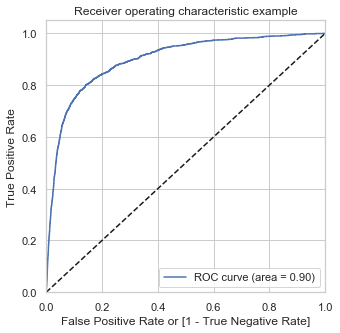

In [174]:
fpr, tpr, thresholds = metrics.roc_curve( y_train, y_pred_proba[:,1], drop_intermediate = False )
draw_roc(y_train, y_pred_proba[:, 1])

**ROC AUC SCORE ON TRAINING DATA**

In [175]:
metrics.roc_auc_score(y_train, y_pred_proba[:, 1])

0.8984139288387739

**ROC AUC SCORE ON TEST DATA**

In [176]:
y_pred_test_proba = logRegressionModel1.predict_proba(X_test);
metrics.roc_auc_score(y_test, y_pred_test_proba[:,1])

0.901552774302864

**SENSITIVITY SPECIFICITY PLOT ON TRAIN DATA**

             prob  accuracy    sensi    speci
0.000000 0.000000  0.081381 1.000000 0.000000
0.100000 0.100000  0.427381 0.974839 0.378881
0.200000 0.200000  0.576952 0.951434 0.543777
0.300000 0.300000  0.676095 0.915155 0.654917
0.400000 0.400000  0.753524 0.878291 0.742471
0.500000 0.500000  0.814095 0.835576 0.812192
0.600000 0.600000  0.863810 0.783499 0.870924
0.700000 0.700000  0.900000 0.715623 0.916334
0.800000 0.800000  0.922000 0.603277 0.950236
0.900000 0.900000  0.927571 0.270334 0.985796


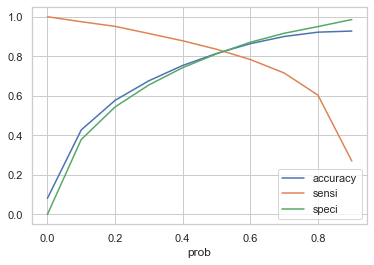

In [177]:
plot_metrics(y_train, y_pred_proba)

Optimal threshold as per sensitivity specificity is somewhere approx 0.52-0.55. We are looking for increasing the sensitivity. Since by default the cut off we used is 0.5, which increases sensitivity compared to optimal 0.55. So we can retain 0.5 as threshold as it increase sensitivity and does not detiriorate roc_auc_score much compared with best threshold

**TEST DATA EVALUATION - CONSOLIDATED**

In [178]:
print(metrics.classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.98      0.81      0.89      8269
           1       0.29      0.85      0.43       732

    accuracy                           0.82      9001
   macro avg       0.63      0.83      0.66      9001
weighted avg       0.93      0.82      0.85      9001



This can be a potential model for prediction as this model has a recall score of 0.85, that means it is able to predict 85% of the churn. But precision on churn prediction is 29% still it is okay as company is more interested on identifying the potential churners as much as possible. 

### A 2. DECISION TREE WITH CLASS WEIGHT

**BASE MODEL WITHOUT CLASS IMBALANCE TREATMENT AND HYPER PARAMETER TUNING**

In [179]:
default_tree = DecisionTreeClassifier(criterion='gini',splitter='best',random_state=42)
default_tree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [180]:
y_pred = default_tree.predict(X_train);
calculate_metrics(y_train, y_pred)

Confusion Matrix: 
[[19291     0]
 [    0  1709]]
Sensitivity:  1.0
Specificity:  1.0
Precision/Positive Predictive Rate:  1.0
Negative Predictive Rate:  1.0


From above results on test data it is clear that tree model is overfitted

In [181]:
y_pred_test = default_tree.predict(X_test)
calculate_metrics(y_test, y_pred_test)

Confusion Matrix: 
[[7683  586]
 [ 468  264]]
Sensitivity:  0.3607
Specificity:  0.9291
Precision/Positive Predictive Rate:  0.3106
Negative Predictive Rate:  0.9426


**BUILDING A MODEL WITH CLASS IMBALANCE TREATMENT**

We can make make the Decision Tree more suitable for learning from extremely imbalanced data follows the idea of cost sensitive learning. Since the Tree classifier tends to be biased towards the majority class, we will place a heavier penalty on misclassifying the minority class. This can be achieved by setting the **class_weight** argument on the Decision Tree class.

This argument takes a dictionary with a mapping of each class value (e.g. 0 and 1) to the weighting. The argument value of **‘balanced‘** can be provided to automatically use the inverse weighting from the training dataset, giving focus to the minority class.


Also we will be using stratified k fold, as it will preserve the class ratio for every fold

**The below step will take 10-15 minutes**

In [182]:
# specify number of folds for k-fold CV
SKfolds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

# parameters to build the model on
parameters = {'max_depth': [ 8, 9, 10, 11, 15, 20], 'min_samples_leaf':[110, 120, 125, 130, 135, 150]}
# instantiate the model
#dtree = DecisionTreeClassifier(max_depth=5,class_weight='balanced',criterion='gini',splitter='best',random_state=42)
dtree = DecisionTreeClassifier(class_weight='balanced',criterion='gini',splitter='best',random_state=42)
# fit tree on training data
tree = GridSearchCV(dtree, 
                    param_grid = parameters, 
                    cv=SKfolds, 
                    scoring=["roc_auc", "f1", "recall"],
                    refit = 'recall',
                    return_train_score=True,
                    verbose =1)
tree.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:  4.0min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=42,
                                              splitter='best'),
  

Let us print the best parameters.

In [183]:
tree.best_params_

{'max_depth': 15, 'min_samples_leaf': 135}

**CV RESULTS - BASED ON RECALL**

In [184]:
cv_result_tree = pd.DataFrame(tree.cv_results_)
cv_result_tree = cv_result_tree[['param_max_depth', 'param_min_samples_leaf',   
                                'mean_train_recall', 'mean_test_recall', 
                                'mean_train_f1', 'mean_test_f1', 
                                'mean_train_roc_auc', 'mean_test_roc_auc']]
cv_result_tree.sort_values(by = ['mean_test_recall'], ascending = False).head(5)

,param_max_depth,param_min_samples_leaf,mean_train_recall,mean_test_recall,mean_train_f1,mean_test_f1,mean_train_roc_auc,mean_test_roc_auc
34,20,135,0.858685,0.768881,0.408972,0.367524,0.908001,0.835764
28,15,135,0.858685,0.768881,0.408972,0.367524,0.908001,0.835764
22,11,135,0.855320,0.768296,0.410712,0.370852,0.907772,0.835573
4,8,135,0.851225,0.767709,0.411552,0.374055,0.902952,0.836730
16,10,135,0.855320,0.767126,0.410712,0.370057,0.907222,0.834671


**CV RESULTS - BASED ON F1**

In [185]:
cv_result_tree.sort_values(by = ['mean_test_f1'], ascending = False).head(5)

,param_max_depth,param_min_samples_leaf,mean_train_recall,mean_test_recall,mean_train_f1,mean_test_f1,mean_train_roc_auc,mean_test_roc_auc
7,9,120,0.845814,0.757759,0.422525,0.382633,0.909375,0.839303
13,10,120,0.851081,0.762438,0.419910,0.380007,0.910854,0.838462
9,9,130,0.848300,0.761858,0.417469,0.379705,0.907331,0.834485
1,8,120,0.847715,0.760102,0.419710,0.379665,0.906168,0.840003
8,9,125,0.848008,0.759519,0.420334,0.378984,0.908652,0.837136


**CV RESULTS - BASED ON ROC AUC**

In [186]:
cv_result_tree.sort_values(by = ['mean_test_roc_auc'], ascending = False).head(5)

,param_max_depth,param_min_samples_leaf,mean_train_recall,mean_test_recall,mean_train_f1,mean_test_f1,mean_train_roc_auc,mean_test_roc_auc
1,8,120,0.847715,0.760102,0.419710,0.379665,0.906168,0.840003
31,20,120,0.853714,0.760098,0.419393,0.377287,0.911722,0.839469
25,15,120,0.853714,0.760098,0.419393,0.377287,0.911722,0.839469
7,9,120,0.845814,0.757759,0.422525,0.382633,0.909375,0.839303
5,8,150,0.844789,0.764784,0.408629,0.372073,0.899600,0.839300


#### From the above table it is clear that the best param which maximise  recall is  max_depth = 15 and min_sample_leaf = 135. But we can see that  max_depth = 11 and min_sample_leaf = 135 is able to provide a much better F1 score( which is comparable with best F1 score), without loosing on Recall much. So we will go ahead with  max_depth = 11 and min_sample_leaf = 135 .

In [187]:
dtree = DecisionTreeClassifier(max_depth = 11, 
                               min_samples_leaf = 135, 
                               class_weight='balanced', 
                               criterion='gini', 
                               splitter='best', 
                               random_state=42)

In [188]:
dtree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=11, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=135, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [189]:
y_pred = dtree.predict(X_train);

**MODEL EVALUATION ON TRAINING DATA**

In [190]:
calculate_metrics(y_train, y_pred)

Confusion Matrix: 
[[15458  3833]
 [  247  1462]]
Sensitivity:  0.8555
Specificity:  0.8013
Precision/Positive Predictive Rate:  0.2761
Negative Predictive Rate:  0.9843


**MODEL EVALUATION ON TEST DATA**

In [191]:
y_pred_test = dtree.predict(X_test)
calculate_metrics(y_test, y_pred_test)

Confusion Matrix: 
[[6528 1741]
 [ 159  573]]
Sensitivity:  0.7828
Specificity:  0.7895
Precision/Positive Predictive Rate:  0.2476
Negative Predictive Rate:  0.9762


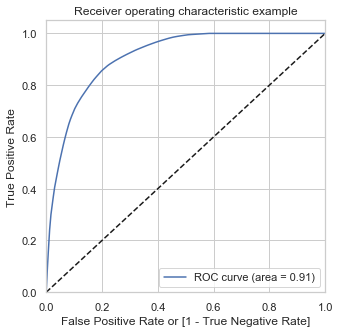

In [192]:
y_pred_proba_tree = dtree.predict_proba(X_train);
fpr, tpr, thresholds = metrics.roc_curve( y_train, y_pred_proba_tree[:,1], drop_intermediate = False )
draw_roc(y_train, y_pred_proba_tree[:, 1])

**ROC AUC SCORE ON TRAINING DATA**

In [193]:
metrics.roc_auc_score(y_train, y_pred_proba_tree[:, 1])

0.9087307575493917

**ROC AUC SCORE ON TEST DATA**

In [194]:
y_pred_proba_tree_test = dtree.predict_proba(X_test);

In [195]:
metrics.roc_auc_score(y_test,y_pred_proba_tree_test[:, 1])

0.8582645729953273

**SENSITIVITY SPECIFICITY PLOT ON TRAIN DATA**

             prob  accuracy    sensi    speci
0.000000 0.000000  0.463381 1.000000 0.415842
0.100000 0.100000  0.532333 0.994734 0.491369
0.200000 0.200000  0.581000 0.985372 0.545177
0.300000 0.300000  0.666000 0.952604 0.640610
0.400000 0.400000  0.765048 0.894090 0.753616
0.500000 0.500000  0.805714 0.855471 0.801306
0.600000 0.600000  0.843667 0.794032 0.848064
0.700000 0.700000  0.882333 0.709187 0.897672
0.800000 0.800000  0.902095 0.617905 0.927272
0.900000 0.900000  0.927429 0.300176 0.982997


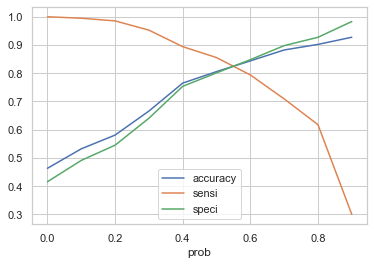

In [196]:
plot_metrics(y_train, y_pred_proba_tree)

##### Optimal threshold is somewhere approx 0.55. We are looking for increasing the sensitivity. Since by default the cut off we used is 0.5, which increases sensitivity compared to optimal 0.55. So we can retain 0.5 as threshold.

**TEST DATA EVALUATION - CONSOLIDATED**

In [197]:
print(metrics.classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.98      0.79      0.87      8269
           1       0.25      0.78      0.38       732

    accuracy                           0.79      9001
   macro avg       0.61      0.79      0.62      9001
weighted avg       0.92      0.79      0.83      9001



As we can see above, both sensitivity, specificity are below 0.8. Also precision is  only 25%. Hence this model is not a good one compared to logisticregression model.

### A. 3. RANDOM FOREST WITH CLASS WEIGHT

**RANDOM FOREST WITH DEFAULT PARAMS AND NO CLASS IMBALANCE TREATMENT**

In [198]:
model = RandomForestClassifier(criterion='gini',
                               max_features='auto', 
                               bootstrap=True, 
                               oob_score=False, 
                               random_state=42, 
                               verbose=0, 
                               warm_start=False)
model.fit(X_train, y_train);

In [199]:
y_pred = model.predict(X_train);
calculate_metrics(y_train, y_pred)

Confusion Matrix: 
[[19291     0]
 [    3  1706]]
Sensitivity:  0.9982
Specificity:  1.0
Precision/Positive Predictive Rate:  1.0
Negative Predictive Rate:  0.9998


In [200]:
y_pred_test = model.predict(X_test)
calculate_metrics(y_test, y_pred_test)

Confusion Matrix: 
[[8225   44]
 [ 658   74]]
Sensitivity:  0.1011
Specificity:  0.9947
Precision/Positive Predictive Rate:  0.6271
Negative Predictive Rate:  0.9259


We can see that default model has poor sensitivity.

**MODEL WITH CLASS IMBALANCE TREATMENT AND HYPER PARAM TUNING**

We can make make the Random Forest more suitable for learning from extremely imbalanced data follows the idea of cost sensitive learning. Since the Tree classifier tends to be biased towards the majority class, we will place a heavier penalty on misclassifying the minority class. This can be achieved by setting the class_weight argument on the Random Forest class.

This argument takes a dictionary with a mapping of each class value (e.g. 0 and 1) to the weighting. The argument value of **‘balanced_subsample‘** can be provided to automatically use the inverse weighting from the every boot strapped sub samples (, instead of the entire training dataset), giving focus to the minority class.

In [201]:
model = RandomForestClassifier(criterion='gini',
                               bootstrap=True, 
                               oob_score=True, 
                               random_state=42, 
                               verbose=0, 
                               warm_start=False, 
                               class_weight="balanced_subsample")


**Below step may take minimum 15-20 minutes**

In [202]:
# specify number of folds for k-fold CV
SKfolds = StratifiedKFold(n_splits = 5, random_state = 42)

# parameters to build the model on
parameters = {'n_estimators': [10, 14, 18, 20, 24, 26], 
              'min_samples_split': [250, 300, 350, 400, 450, 500, 550]}

# fit tree on training data
modelcv = GridSearchCV(model, 
                    param_grid = parameters, 
                    cv=SKfolds, 
                    scoring = ["roc_auc", "f1", "recall"],
                    refit = 'recall',
                    return_train_score=True,
                    verbose =1)
modelcv.fit(X_train, y_train)

Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 210 out of 210 | elapsed:  7.8min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=False),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced_subsample',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_sa...
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                      

In [203]:
modelcv.best_params_

{'min_samples_split': 500, 'n_estimators': 18}

It is observed that model best parameter changing on every run even after setting random_state for RandomForestClassifier as well as for StratifiedKfold. Going ahead with current best value that maximising the recall. n_estimators = 18, min_samples_split = 500

**CV RESULTS - BASED ON RECALL**

In [204]:
cv_result_ran_forest = pd.DataFrame(modelcv.cv_results_)
cv_result_ran_forest = cv_result_ran_forest[['param_n_estimators', 'param_min_samples_split',    
                                            'mean_train_recall', 'mean_test_recall', 
                                            'mean_train_f1', 'mean_test_f1', 
                                            'mean_train_roc_auc', 'mean_test_roc_auc']]
cv_result_ran_forest.sort_values(by = ['mean_test_recall'], ascending = False).head(5)

,param_n_estimators,param_min_samples_split,mean_train_recall,mean_test_recall,mean_train_f1,mean_test_f1,mean_train_roc_auc,mean_test_roc_auc
32,18,500,0.820945,0.733164,0.503110,0.452222,0.922587,0.870591
35,26,500,0.820361,0.731992,0.510598,0.457486,0.924880,0.872885
41,26,550,0.819484,0.731402,0.504250,0.455196,0.921909,0.871153
34,24,500,0.821385,0.730826,0.511452,0.458623,0.924438,0.871682
38,18,550,0.820362,0.730818,0.496804,0.448907,0.919941,0.869709


**CV RESULTS - BASED ON F1**

In [205]:
cv_result_ran_forest.sort_values(by = ['mean_test_f1'], ascending = False).head(5)

,param_n_estimators,param_min_samples_split,mean_train_recall,mean_test_recall,mean_train_f1,mean_test_f1,mean_train_roc_auc,mean_test_roc_auc
5,26,250,0.838063,0.692207,0.579274,0.485782,0.948060,0.877200
4,24,250,0.840549,0.689287,0.579991,0.485203,0.947570,0.876349
3,20,250,0.838210,0.686349,0.575604,0.480913,0.946436,0.874420
2,18,250,0.838648,0.686941,0.572778,0.478455,0.945538,0.874137
11,26,300,0.838794,0.702744,0.560505,0.478384,0.942070,0.872669


**CV RESULTS - BASED ON ROC AUC**

In [206]:
cv_result_ran_forest.sort_values(by = ['mean_test_roc_auc'], ascending = False).head(5)

,param_n_estimators,param_min_samples_split,mean_train_recall,mean_test_recall,mean_train_f1,mean_test_f1,mean_train_roc_auc,mean_test_roc_auc
5,26,250,0.838063,0.692207,0.579274,0.485782,0.948060,0.877200
4,24,250,0.840549,0.689287,0.579991,0.485203,0.947570,0.876349
23,26,400,0.826798,0.713877,0.531456,0.462257,0.932407,0.874793
17,26,350,0.829285,0.709758,0.543210,0.474778,0.937247,0.874475
3,20,250,0.838210,0.686349,0.575604,0.480913,0.946436,0.874420


With n_estimators = 18, min_samples_split = 500, we found that max_depth = 5, maximises the Sensitivity

In [207]:
model = RandomForestClassifier(n_estimators = 18,
                               min_samples_split = 500,
                               max_depth = 5,
                               criterion='gini',
                               bootstrap=True,
                               max_features = 'auto',
                               oob_score=True, 
                               random_state=42, 
                               verbose=0, 
                               warm_start=False, 
                               class_weight="balanced_subsample")
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=500, min_weight_fraction_leaf=0.0,
                       n_estimators=18, n_jobs=None, oob_score=True,
                       random_state=42, verbose=0, warm_start=False)

**MODEL EVALUATION ON TRAINING DATA**

In [208]:
y_pred = model.predict(X_train);

In [209]:
calculate_metrics(y_train, y_pred)

Confusion Matrix: 
[[16345  2946]
 [  351  1358]]
Sensitivity:  0.7946
Specificity:  0.8473
Precision/Positive Predictive Rate:  0.3155
Negative Predictive Rate:  0.979


**MODEL EVALUATION ON TEST DATA**

In [210]:
y_pred_test = model.predict(X_test)
calculate_metrics(y_test, y_pred_test)

Confusion Matrix: 
[[7010 1259]
 [ 187  545]]
Sensitivity:  0.7445
Specificity:  0.8477
Precision/Positive Predictive Rate:  0.3021
Negative Predictive Rate:  0.974


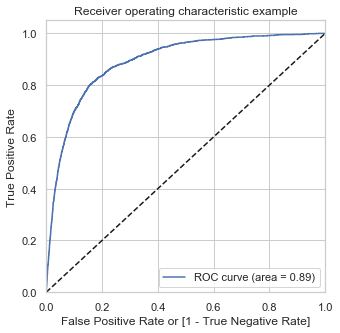

In [211]:
y_pred_proba_rf = model.predict_proba(X_train);
fpr, tpr, thresholds = metrics.roc_curve(y_train, y_pred_proba_rf[:,1], drop_intermediate = False )
draw_roc(y_train, y_pred_proba_rf[:, 1])

**ROC AUC SCORE FOR TRAINING DATA**

In [212]:
metrics.roc_auc_score(y_train, y_pred_proba_rf[:,1])

0.8919068636772169

**ROC AUC SCORE FOR TEST DATA**

In [213]:
y_pred_proba_rf_test = model.predict_proba(X_test);

In [214]:
metrics.roc_auc_score(y_test, y_pred_proba_rf_test[:,1])

0.8711250030563822

**TEST DATA EVALUATION - CONSOLIDATED**

In [215]:
print(metrics.classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.97      0.85      0.91      8269
           1       0.30      0.74      0.43       732

    accuracy                           0.84      9001
   macro avg       0.64      0.80      0.67      9001
weighted avg       0.92      0.84      0.87      9001



With this model recall rate is low, as company looks to identify more churners this might not be a good model

### A. 4. XG BOOST WITH CLASS WEIGHT

XGBoost implementation provides a hyperparameter designed to tune the behavior of the algorithm for imbalanced classification problems; this is the scale_pos_weight hyperparameter. By default, the scale_pos_weight hyperparameter is set to the value of 1.0 and has the effect of weighing the balance of positive examples, relative to negative examples when boosting decision trees. For an imbalanced binary classification dataset, the negative class refers to the majority class (class 0) and the positive class refers to the minority class (class 1).


The scale_pos_weight value is used to scale the gradient for the positive class. This has the effect of scaling errors made by the model during training on the positive class and encourages the model to over-correct them. In turn, this can help the model achieve better performance when making predictions on the positive class. Pushed too far, it may result in the model overfitting the positive class at the cost of worse performance on the negative class or both classes.

As such, the scale_pos_weight can be used to train a class-weighted or cost-sensitive version of XGBoost for imbalanced classification. A sensible default value to set for the scale_pos_weight hyperparameter is the inverse of the class distribution. In our case this value is 11.29 (number of negative clas/number of positive class)

We have referred the following post for understanding purpose:
https://machinelearningmastery.com/xgboost-for-imbalanced-classification/

In [216]:
weight = list(y.values).count(0)/ list(y.values).count(1)
weight

11.29045473166735

In [217]:
model = XGBClassifier(scale_pos_weight = weight)
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=11.29045473166735, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [218]:
y_pred = model.predict(X_train);
calculate_metrics(y_train, y_pred)

Confusion Matrix: 
[[19232    59]
 [    0  1709]]
Sensitivity:  1.0
Specificity:  0.9969
Precision/Positive Predictive Rate:  0.9666
Negative Predictive Rate:  1.0


In [219]:
y_pred_test = model.predict(X_test)
calculate_metrics(y_test, y_pred_test)

Confusion Matrix: 
[[7938  331]
 [ 360  372]]
Sensitivity:  0.5082
Specificity:  0.96
Precision/Positive Predictive Rate:  0.5292
Negative Predictive Rate:  0.9566


### Tuning Hyper Parameter

Though we have given scale_pos_weight = 11.29, we can see test sensitivity is bad. Let us tune it further. We will test with higher weight values, and a range of eta.(Learning rate)

### Below is the grid search for XGBClassifier, it takes considerable amount of time (about 1 hr). 

In [220]:
model = XGBClassifier(random_state = 42)

##### specify number of folds for k-fold CV
SKfolds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

##### parameters to build the model on
##original param
#parameters = {'scale_pos_weight': [11.29, 15,  18, 20, 21, 22, 23, 24, 26],  'eta': [0.12, 0.15, 0.18, 0.20, 0.21, 0.22, 0.23]}

# since it takes more time, after rinning above once and finding optimal params,  we are using smaller set.
parameters = {'scale_pos_weight': [11.29, 15, 20,  22, 24, 26],  'eta': [0.12, 0.15, 0.20]}

##### fit tree on training data
modelcv = GridSearchCV(model, 
                    param_grid = parameters, 
                    cv=SKfolds, 
                    scoring= ['recall', 'f1', 'roc_auc'],
                    refit = 'recall',
                    return_train_score=True,
                    verbose =1)
modelcv.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed: 22.2min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_we...
                                     random_state=42, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None,
                                     validate_parameters=False,
                                     verbosity=None),
         

In [221]:
modelcv.best_params_

{'eta': 0.12, 'scale_pos_weight': 26}

**CV RESULTS - BASED ON RECALL**

In [222]:
cv_result_xgb = pd.DataFrame(modelcv.cv_results_)
cv_result_xgb = cv_result_xgb[['param_scale_pos_weight','param_eta',     
                                'mean_train_recall', 'mean_test_recall', 
                                'mean_train_f1', 'mean_test_f1', 
                                'mean_train_roc_auc', 'mean_test_roc_auc']]
cv_result_xgb.sort_values(by = ['mean_test_recall'], ascending = False).head(5)

,param_scale_pos_weight,param_eta,mean_train_recall,mean_test_recall,mean_train_f1,mean_test_f1,mean_train_roc_auc,mean_test_roc_auc
5,26,0.120000,1.000000,0.671750,0.762068,0.496601,0.998356,0.879174
4,24,0.120000,1.000000,0.669407,0.764421,0.499879,0.998382,0.880093
3,22,0.120000,1.000000,0.667654,0.773133,0.503629,0.998270,0.880686
2,20,0.120000,1.000000,0.654201,0.784283,0.502784,0.998534,0.881155
1,15,0.120000,1.000000,0.644246,0.809879,0.515954,0.998449,0.884217


**CV RESULTS - BASED ON F1**

In [223]:
cv_result_xgb.sort_values(by = ['mean_test_f1'], ascending = False).head(5)

,param_scale_pos_weight,param_eta,mean_train_recall,mean_test_recall,mean_train_f1,mean_test_f1,mean_train_roc_auc,mean_test_roc_auc
6,11.290000,0.150000,1.000000,0.589837,0.892217,0.527760,0.999632,0.882452
0,11.290000,0.120000,0.999122,0.619089,0.843983,0.526313,0.998738,0.885699
12,11.290000,0.200000,1.000000,0.534832,0.955793,0.521169,0.999973,0.883195
14,20,0.200000,1.000000,0.571698,0.925727,0.517991,0.999954,0.878231
1,15,0.120000,1.000000,0.644246,0.809879,0.515954,0.998449,0.884217


**CV RESULTS - BASED ON ROC AUC**

In [224]:
cv_result_xgb.sort_values(by = ['mean_test_roc_auc'], ascending = False).head(5)

,param_scale_pos_weight,param_eta,mean_train_recall,mean_test_recall,mean_train_f1,mean_test_f1,mean_train_roc_auc,mean_test_roc_auc
0,11.290000,0.120000,0.999122,0.619089,0.843983,0.526313,0.998738,0.885699
1,15,0.120000,1.000000,0.644246,0.809879,0.515954,0.998449,0.884217
12,11.290000,0.200000,1.000000,0.534832,0.955793,0.521169,0.999973,0.883195
6,11.290000,0.150000,1.000000,0.589837,0.892217,0.527760,0.999632,0.882452
2,20,0.120000,1.000000,0.654201,0.784283,0.502784,0.998534,0.881155


Best params are 'eta': 0.12, 'scale_pos_weight': 26; along with these params we found that max_depth = 3 maximises recall

In [225]:
model = XGBClassifier(scale_pos_weight = 26, max_depth=3, eta = 0.12, random_state = 42)
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.12, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints=None,
              learning_rate=0.119999997, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=26, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

**MODEL EVALUATION ON TRAINING DATA**

In [226]:
y_pred = model.predict(X_train);
calculate_metrics(y_train, y_pred)

Confusion Matrix: 
[[14606  4685]
 [   75  1634]]
Sensitivity:  0.9561
Specificity:  0.7571
Precision/Positive Predictive Rate:  0.2586
Negative Predictive Rate:  0.9949


**MODEL EVALUATION ON TEST DATA**

In [227]:
y_pred_test = model.predict(X_test)
calculate_metrics(y_test, y_pred_test)

Confusion Matrix: 
[[6215 2054]
 [  83  649]]
Sensitivity:  0.8866
Specificity:  0.7516
Precision/Positive Predictive Rate:  0.2401
Negative Predictive Rate:  0.9868


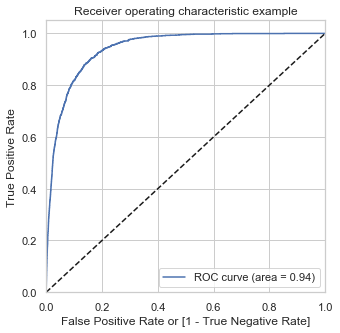

In [228]:
y_pred_proba_xgb  = model.predict_proba(X_train);
fpr, tpr, thresholds = metrics.roc_curve(y_train, y_pred_proba_xgb[:,1], drop_intermediate = False )
draw_roc(y_train, y_pred_proba_xgb[:, 1])

**ROC AUC SCORE FOR TRAINING DATA**

In [229]:
metrics.roc_auc_score(y_train, y_pred_proba_xgb[:,1])

0.9424338711354983

**ROC AUC SCORE FOR TEST DATA**

In [230]:
y_pred_proba_xgb_test = model.predict_proba(X_test);

In [231]:
metrics.roc_auc_score(y_test, y_pred_proba_xgb_test[:,1])

0.9005221952820032

**TEST DATA EVALUATION - CONSOLIDATED**

In [232]:
print(metrics.classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.99      0.75      0.85      8269
           1       0.24      0.89      0.38       732

    accuracy                           0.76      9001
   macro avg       0.61      0.82      0.62      9001
weighted avg       0.93      0.76      0.81      9001



So far this model gave mximum recall, but both spesificity and precision are slightly low compared to logistic model. Still we can consider this as a potential model

## B. MODEL WITH OVERSAMPLING USING SMOTE

### NOTE: 

##### PLEASE INSTALL imbalanced-learn PACKAGE BEFORE RUNNING TE BELOW COMMAND FOR ANACONDA USERS: conda install -c conda-forge imbalanced-learn

As we seen above with class weight, both Logistic regression and XGBoostClassifier performed well. So let we will try those two models with over sampling. We will us over sample the minority calss on training data so that both the class will have same number of records.

In [233]:
from imblearn.over_sampling import SMOTE

print("Shape of X_train before applying SMOTE: ", X_train.shape)
print("Number of Non Churn before applying SMOTE: ", len(y_train[y_train == 0]))
print("Number of Churn before applying SMOTE: ", len(y_train[y_train == 1]))

smote = SMOTE(random_state = 42)

X_train_smote, y_train_smote = smote.fit_sample(X_train, y_train.ravel())

Shape of X_train before applying SMOTE:  (21000, 73)
Number of Non Churn before applying SMOTE:  19291
Number of Churn before applying SMOTE:  1709


In [234]:
print("Shape of X_train after applying SMOTE: ", X_train_smote.shape)
print("Number of Non Churn after applying SMOTE: ", len(y_train_smote[y_train_smote == 0]))
print("Number of Churn after applying SMOTE: ", len(y_train_smote[y_train_smote == 1]))

Shape of X_train after applying SMOTE:  (38582, 73)
Number of Non Churn after applying SMOTE:  19291
Number of Churn after applying SMOTE:  19291


### B 1. LOGISTIC REGRESSION WITH SMOTE:

In [235]:
logRegressionCV = LogisticRegression(class_weight = 'balanced', random_state = 42)
params = {'C': [.01, 0.1, 0.2, 0.5, 1, 2, 3, 4, 5, 10, 100, 200, 500, 1000], 'penalty': ['l1', 'l2']}
SKfolds = StratifiedKFold(n_splits = 5,  shuffle = True, random_state = 42)

# create gridsearch object
model = GridSearchCV(estimator=logRegressionCV, 
                     cv=SKfolds, 
                     param_grid=params, 
                     scoring=['f1', 'recall', 'roc_auc'], 
                     verbose=1,
                     refit = 'recall',
                     return_train_score=True)
model.fit(X_train_smote, y_train_smote)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:   23.8s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=42, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.01, 0.1, 0.2, 0.5, 1, 2, 3, 4, 5, 10, 100, 200,
                               500, 1000],
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit='recall', return_train_score=True,
             scoring=['f

In [236]:
model.best_params_

{'C': 0.1, 'penalty': 'l2'}

In [237]:
cv_result_log_reg = pd.DataFrame(model.cv_results_)
cv_result_log_reg = cv_result_log_reg[['param_C', 'param_penalty', 
                                       'mean_train_recall', 'mean_test_recall', 
                                       'mean_train_f1', 'mean_test_f1', 
                                       'mean_train_roc_auc', 'mean_test_roc_auc']]

**CV RESULTS - BASED ON RECALL**

In [238]:
cv_result_log = cv_result_log_reg.sort_values(by =['mean_test_recall'], ascending = False )
cv_result_log.head(5)

,param_C,param_penalty,mean_train_recall,mean_test_recall,mean_train_f1,mean_test_f1,mean_train_roc_auc,mean_test_roc_auc
3,0.100000,l2,0.858729,0.857809,0.845342,0.844323,0.918339,0.916984
5,0.200000,l2,0.858768,0.857654,0.845326,0.844235,0.918348,0.916989
1,0.010000,l2,0.858328,0.857602,0.845318,0.844376,0.918158,0.916868
7,0.500000,l2,0.858781,0.857498,0.845317,0.844168,0.918352,0.916992
9,1,l2,0.858833,0.857498,0.845341,0.844190,0.918354,0.916994


**CV RESULTS - BASED ON F1**

In [239]:
cv_result_log = cv_result_log_reg.sort_values(by =['mean_test_f1'], ascending = False )
cv_result_log.head(5)

,param_C,param_penalty,mean_train_recall,mean_test_recall,mean_train_f1,mean_test_f1,mean_train_roc_auc,mean_test_roc_auc
1,0.010000,l2,0.858328,0.857602,0.845318,0.844376,0.918158,0.916868
3,0.100000,l2,0.858729,0.857809,0.845342,0.844323,0.918339,0.916984
5,0.200000,l2,0.858768,0.857654,0.845326,0.844235,0.918348,0.916989
9,1,l2,0.858833,0.857498,0.845341,0.844190,0.918354,0.916994
11,2,l2,0.858846,0.857498,0.845348,0.844169,0.918355,0.916993


**CV RESULTS - BASED ON ROC AUC**

In [240]:
cv_result_log = cv_result_log_reg.sort_values(by =['mean_test_roc_auc'], ascending = False )
cv_result_log.head(5)

,param_C,param_penalty,mean_train_recall,mean_test_recall,mean_train_f1,mean_test_f1,mean_train_roc_auc,mean_test_roc_auc
21,100,l2,0.858846,0.857498,0.845348,0.844147,0.918356,0.916994
27,1000,l2,0.858846,0.857498,0.845348,0.844147,0.918356,0.916994
19,10,l2,0.858846,0.857498,0.845348,0.844147,0.918356,0.916994
25,500,l2,0.858846,0.857498,0.845348,0.844147,0.918356,0.916994
23,200,l2,0.858846,0.857498,0.845348,0.844147,0.918356,0.916994


In [241]:
logRegressionModel = LogisticRegression(class_weight = 'balanced', random_state = 42, C= 0.01, penalty= 'l2')
logRegressionModel.fit(X_train_smote, y_train_smote)

LogisticRegression(C=0.01, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [242]:
y_train_pred = logRegressionModel.predict(X_train_smote)

**MODEL EVALUATION ON TRAINING DATA**

In [243]:
calculate_metrics(y_train_smote, y_train_pred)

Confusion Matrix: 
[[15955  3336]
 [ 2738 16553]]
Sensitivity:  0.8581
Specificity:  0.8271
Precision/Positive Predictive Rate:  0.8323
Negative Predictive Rate:  0.8535


**MODEL EVALUATION ON TEST DATA**

In [244]:
y_test_pred = logRegressionModel.predict(X_test)
calculate_metrics(y_test, y_test_pred)

Confusion Matrix: 
[[6838 1431]
 [ 126  606]]
Sensitivity:  0.8279
Specificity:  0.8269
Precision/Positive Predictive Rate:  0.2975
Negative Predictive Rate:  0.9819


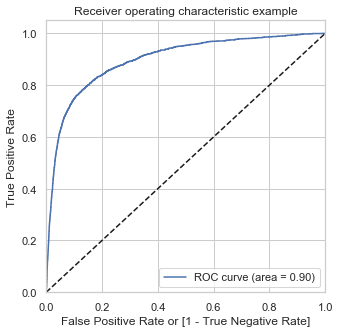

In [245]:
y_pred_proba_imbrf  = model.predict_proba(X_train);
fpr, tpr, thresholds = metrics.roc_curve(y_train, y_pred_proba_imbrf[:,1], drop_intermediate = False )
draw_roc(y_train, y_pred_proba_imbrf[:, 1])

**TEST DATA EVALUATION - CONSOLIDATED**

In [246]:
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.98      0.83      0.90      8269
           1       0.30      0.83      0.44       732

    accuracy                           0.83      9001
   macro avg       0.64      0.83      0.67      9001
weighted avg       0.93      0.83      0.86      9001



We can see the class weight version is slightly better that over sampled logistic regression version. So we will go ahead with class weight version of the logistic regression over this model

### B 2. XGBOOST

We will build a base version of XGBoostClassifier with oversampled train data for comparison.

In [247]:
xgb_model = XGBClassifier(random_state = 42)
xgb_model.fit(X_train_smote, y_train_smote)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [248]:
y_train_pred = xgb_model.predict(X_train_smote)
calculate_metrics(y_train_smote, y_train_pred)

Confusion Matrix: 
[[19098   193]
 [   18 19273]]
Sensitivity:  0.9991
Specificity:  0.99
Precision/Positive Predictive Rate:  0.9901
Negative Predictive Rate:  0.9991


In [249]:
y_test_pred = xgb_model.predict(X_test)
calculate_metrics(y_test, y_test_pred)

Confusion Matrix: 
[[7722  547]
 [ 287  445]]
Sensitivity:  0.6079
Specificity:  0.9338
Precision/Positive Predictive Rate:  0.4486
Negative Predictive Rate:  0.9642


Let us fine tune eta and max_depth.

**Below step takes almost 1 hour to complete**

In [250]:
xgb_model = XGBClassifier(random_state = 42)
##### specify number of folds for k-fold CV
Kfolds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

##### parameters to build the model on
parameters = {'eta': [0.1, 0.20, 0.23, 0.25], 'max_depth':[4, 5, 6]}

##### fit tree on training data
modelcv = GridSearchCV(xgb_model, 
                    param_grid = parameters, 
                    cv=Kfolds, 
                    scoring= ['recall', 'f1', 'roc_auc'],
                    refit = 'recall',
                    return_train_score=True,
                    verbose =1)
modelcv.fit(X_train_smote, y_train_smote)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 30.4min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_we...
                                     objective='binary:logistic',
                                     random_state=42, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None,
                                     validate_parameters=Fals

In [251]:
modelcv.best_params_

{'eta': 0.25, 'max_depth': 6}

Best params are eta=0.25, max_depth = 6

**CV RESULTS - BASED ON RECALL**

In [252]:
cv_result_xgb = pd.DataFrame(modelcv.cv_results_)
cv_result_xgb = cv_result_xgb[['param_max_depth','param_eta',     
                                'mean_train_recall', 'mean_test_recall', 
                                'mean_train_f1', 'mean_test_f1', 
                                'mean_train_roc_auc', 'mean_test_roc_auc']]
cv_result_xgb.sort_values(by = ['mean_test_recall'], ascending = False).head(5)

,param_max_depth,param_eta,mean_train_recall,mean_test_recall,mean_train_f1,mean_test_f1,mean_train_roc_auc,mean_test_roc_auc
11,6,0.250000,0.998471,0.975533,0.992420,0.950580,0.999714,0.985094
8,6,0.230000,0.997641,0.972111,0.990340,0.948848,0.999485,0.984752
5,6,0.200000,0.994751,0.970193,0.985537,0.946259,0.998865,0.983448
10,5,0.250000,0.982323,0.952516,0.969775,0.932576,0.995273,0.977093
7,5,0.230000,0.980963,0.950650,0.967596,0.930496,0.994392,0.976074


**CV RESULTS - BASED ON F1**

In [253]:
cv_result_xgb.sort_values(by = ['mean_test_f1'], ascending = False).head(5)

,param_max_depth,param_eta,mean_train_recall,mean_test_recall,mean_train_f1,mean_test_f1,mean_train_roc_auc,mean_test_roc_auc
11,6,0.250000,0.998471,0.975533,0.992420,0.950580,0.999714,0.985094
8,6,0.230000,0.997641,0.972111,0.990340,0.948848,0.999485,0.984752
5,6,0.200000,0.994751,0.970193,0.985537,0.946259,0.998865,0.983448
10,5,0.250000,0.982323,0.952516,0.969775,0.932576,0.995273,0.977093
7,5,0.230000,0.980963,0.950650,0.967596,0.930496,0.994392,0.976074


**CV RESULTS - BASED ON ROC AUC**

In [254]:
cv_result_xgb.sort_values(by = ['mean_test_roc_auc'], ascending = False).head(5)

,param_max_depth,param_eta,mean_train_recall,mean_test_recall,mean_train_f1,mean_test_f1,mean_train_roc_auc,mean_test_roc_auc
11,6,0.250000,0.998471,0.975533,0.992420,0.950580,0.999714,0.985094
8,6,0.230000,0.997641,0.972111,0.990340,0.948848,0.999485,0.984752
5,6,0.200000,0.994751,0.970193,0.985537,0.946259,0.998865,0.983448
10,5,0.250000,0.982323,0.952516,0.969775,0.932576,0.995273,0.977093
7,5,0.230000,0.980963,0.950650,0.967596,0.930496,0.994392,0.976074


In [255]:
model_xgb = XGBClassifier( max_depth=6, eta = 0.25, random_state = 42)
model_xgb.fit(X_train_smote, y_train_smote)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.25, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints=None,
              learning_rate=0.25, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

**The below cell may take a 20-30 minutes**

In [256]:
xgb_model = XGBClassifier( max_depth=6, eta = 0.25, random_state = 42)
Kfolds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

##### parameters to build the model on
parameters = {'n_estimators':[50, 100, 200, 300]}

##### fit tree on training data
modelcv = GridSearchCV(xgb_model, 
                    param_grid = parameters, 
                    cv=Kfolds, 
                    scoring= ['recall', 'f1', 'roc_auc'],
                    refit = 'recall',
                    return_train_score=True,
                    verbose =1)
modelcv.fit(X_train_smote, y_train_smote)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 14.9min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, eta=0.25,
                                     gamma=None, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=6, min_ch...
                                     objective='binary:logistic',
                                     random_state=42, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None,
                       

In [257]:
modelcv.best_params_

{'n_estimators': 300}

**MODEL EVALUATION ON TRAINING DATA**

In [258]:
mode_xgb = XGBClassifier( max_depth= 6, eta = 0.25, n_estimators = 300, random_state = 42)
mode_xgb.fit(X_train_smote, y_train_smote);
y_pred = mode_xgb.predict(X_train_smote);
calculate_metrics(y_train_smote, y_pred)

Confusion Matrix: 
[[19291     0]
 [    0 19291]]
Sensitivity:  1.0
Specificity:  1.0
Precision/Positive Predictive Rate:  1.0
Negative Predictive Rate:  1.0


**MODEL EVALUATION ON TEST DATA**

In [259]:
y_pred_test = mode_xgb.predict(X_test)
calculate_metrics(y_test, y_pred_test)

Confusion Matrix: 
[[7852  417]
 [ 307  425]]
Sensitivity:  0.5806
Specificity:  0.9496
Precision/Positive Predictive Rate:  0.5048
Negative Predictive Rate:  0.9624


Model seems to be overfitting the test data

We can see the Test Sensitivity and Precision both are bad. Now lets see how the precision recall curve looks like on train data. And arrive on a better threshold which maximize the recall.

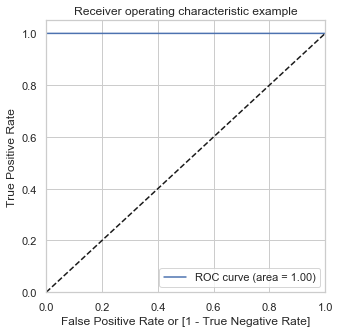

In [260]:
y_pred_proba_xgb  =mode_xgb.predict_proba(X_train_smote);
fpr, tpr, thresholds = metrics.roc_curve(y_train_smote, y_pred_proba_xgb[:,1], drop_intermediate = False )
draw_roc(y_train_smote, y_pred_proba_xgb[:, 1])

**ROC AUC SCORE FOR TRAINING DATA**

In [261]:
metrics.roc_auc_score(y_train_smote, y_pred_proba_xgb[:,1])

1.0

             prob  accuracy    sensi    speci
0.000000 0.000000  0.500000 1.000000 0.000000
0.100000 0.100000  0.998238 1.000000 0.996475
0.200000 0.200000  0.999948 1.000000 0.999896
0.300000 0.300000  0.999974 1.000000 0.999948
0.400000 0.400000  1.000000 1.000000 1.000000
0.500000 0.500000  1.000000 1.000000 1.000000
0.600000 0.600000  1.000000 1.000000 1.000000
0.700000 0.700000  1.000000 1.000000 1.000000
0.800000 0.800000  1.000000 1.000000 1.000000
0.900000 0.900000  0.999948 0.999896 1.000000


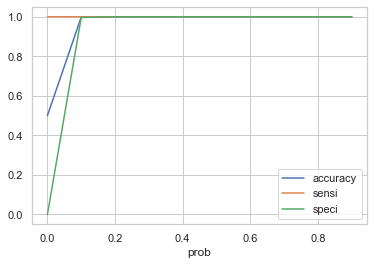

In [262]:
plot_metrics(y_train_smote, y_pred_proba_xgb)

Lets select a threshold as low as 0.1 to maximise recall at cost of precision

In [263]:
y_pred_proba_test_xgb = mode_xgb.predict_proba(X_test)
y_pred_proba_test_xgb = list(y_pred_proba_test_xgb[:, -1])
y_pred_test_final = list(map(lambda x: 1 if x>0.1 else 0, y_pred_proba_test_xgb))
calculate_metrics(y_test, y_pred_test_final)

Confusion Matrix: 
[[7311  958]
 [ 194  538]]
Sensitivity:  0.735
Specificity:  0.8841
Precision/Positive Predictive Rate:  0.3596
Negative Predictive Rate:  0.9742


**ROC AUC SCORE FOR TEST DATA**

In [264]:
y_pred_proba_xgb_test =mode_xgb.predict_proba(X_test);

In [265]:
metrics.roc_auc_score(y_test, y_pred_proba_xgb_test[:,1])

0.8859654731246533

**TEST DATA EVALUATION - CONSOLIDATED**

In [266]:
print(metrics.classification_report(y_test, y_pred_test_final))

              precision    recall  f1-score   support

           0       0.97      0.88      0.93      8269
           1       0.36      0.73      0.48       732

    accuracy                           0.87      9001
   macro avg       0.67      0.81      0.70      9001
weighted avg       0.92      0.87      0.89      9001



Even after tuning the thershold to a least value this model is not giving good recall. Hence we will not use this model as a candidate.

# C. MODEL FOR EXPLAINING FEATURE IMOPRTANCE:

### C1. RANDOM FOREST WITH CLASS WEIGHT TRAINED ON A DATA SET WITHOUT PCA

We will use RandomForest model for explaining feature importance. Also here we are using the scaled data set where it is not transformed with PCA

In [267]:
model = RandomForestClassifier(criterion='gini',
                               max_features='auto', 
                               bootstrap=True, 
                               oob_score=False, 
                               random_state=42, 
                               verbose=0, 
                               warm_start=False, 
                               class_weight="balanced_subsample")

**Below step may take 15-20 minutes**

In [268]:
# specify number of folds for k-fold CV
SKfolds = StratifiedKFold(n_splits = 5, random_state = 42)

# parameters to build the model on
parameters = {'n_estimators': [ 10, 15, 20, 25, 30, 40, 50], 'min_samples_split': [50, 100, 150, 200, 250, 300, 350]}

# fit tree on training data
model = GridSearchCV(model, 
                    param_grid = parameters, 
                    cv=SKfolds, 
                    scoring=['recall', 'f1', 'roc_auc'],
                    refit = 'recall',
                    return_train_score=True,
                    verbose =1)
model.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 49 candidates, totalling 245 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 245 out of 245 | elapsed: 12.6min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=False),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced_subsample',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_sa...
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                      

In [269]:
model.best_params_

{'min_samples_split': 350, 'n_estimators': 10}

In [270]:
cv_result_rf = pd.DataFrame(model.cv_results_)
cv_result_rf = cv_result_rf[['param_n_estimators', 'param_min_samples_split',  'mean_train_recall', 'mean_test_recall', 'mean_train_f1', 'mean_test_f1', 'mean_train_roc_auc', 'mean_test_roc_auc']]
cv_result_rf.sort_values(by = ['mean_test_recall'], ascending = False).head(5)

,param_n_estimators,param_min_samples_split,mean_train_recall,mean_test_recall,mean_train_f1,mean_test_f1,mean_train_roc_auc,mean_test_roc_auc
42,10,350,0.833090,0.781136,0.566015,0.534221,0.949332,0.917049
35,10,300,0.846547,0.780565,0.575857,0.537226,0.952559,0.917157
44,20,350,0.836893,0.780556,0.574513,0.541262,0.952668,0.921514
48,50,350,0.843769,0.778810,0.577970,0.540723,0.954283,0.922657
40,40,300,0.849765,0.778229,0.585652,0.541755,0.956787,0.922348


In [271]:
model = RandomForestClassifier(criterion='gini',
                               min_samples_split = 350,
                               n_estimators = 10,
                               max_features='auto', 
                               bootstrap=True, 
                               oob_score=False, 
                               random_state=42, 
                               verbose=0, 
                               warm_start=False, 
                               class_weight="balanced_subsample")
model.fit(X_train_scaled, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=350, min_weight_fraction_leaf=0.0,
                       n_estimators=10, n_jobs=None, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

In [272]:
y_pred_rf_train = model.predict(X_train_scaled)

**MODEL EVALUATION ON TRAINING DATA**

In [273]:
calculate_metrics(y_train, y_pred_rf_train)

Confusion Matrix: 
[[17456  1835]
 [  255  1454]]
Sensitivity:  0.8508
Specificity:  0.9049
Precision/Positive Predictive Rate:  0.4421
Negative Predictive Rate:  0.9856


**MODEL EVALUATION ON TEST DATA**

In [274]:
y_pred_rf_test = model.predict(X_test_scaled)
calculate_metrics(y_test, y_pred_rf_test)

Confusion Matrix: 
[[7480  789]
 [ 137  595]]
Sensitivity:  0.8128
Specificity:  0.9046
Precision/Positive Predictive Rate:  0.4299
Negative Predictive Rate:  0.982


**ROC AUC SCORE TEST**

In [275]:
y_pred_proba_rf_test = model.predict_proba(X_test_scaled)
metrics.roc_auc_score(y_test, y_pred_proba_rf_test[:,1])

0.9245000089213318

In [276]:
attibute = high_value_customers.columns

**TEST DATA EVALUATION - CONSOLIDATED**

In [277]:
print(metrics.classification_report(y_test, y_pred_rf_test))

              precision    recall  f1-score   support

           0       0.98      0.90      0.94      8269
           1       0.43      0.81      0.56       732

    accuracy                           0.90      9001
   macro avg       0.71      0.86      0.75      9001
weighted avg       0.94      0.90      0.91      9001



This model though its created for feature explanation purpose has a decent recall score of 0.81 and able to achieve best precision of 0.43 and an F1 score of 0.56. Let us consider this model also as a candidate for prediction

**FEATURE IMPORTANCE**

We will print the top 25 features as per the tuned RandomForest Model

**TOP 25 FEATURES**

In [278]:
importance = model.feature_importances_

feature_importance = pd.DataFrame({'Features': attibute, 'Importance': importance*100})
feature_importance = feature_importance[['Features', 'Importance']]

# sort features
feature_importance = feature_importance.sort_values(by = ['Importance'], ascending = False)
feature_importance.head(25)

,Features,Importance
59,loc_ic_t2m_mou_8,14.651430
101,last_day_rch_amt_8,7.825429
80,total_ic_mou_8,5.693770
95,total_rech_amt_8,5.243392
153,total_data_rech_amnt_8,4.176967
77,std_ic_mou_8,4.162901
107,max_rech_data_8,3.804910
116,av_rech_amt_data_8,3.782552
65,loc_ic_mou_8,3.594479
20,loc_og_t2m_mou_8,3.452209


# CONCLUSION

## 1. FEATURE IMPORTANCE AND STRATEGIES:

**TOP 25 FEATURES**

loc_ic_t2m_mou_8 - Local incoming call(Operator T to other operator mobile) minutes of usage for 8th Month

last_day_rch_amt_8 - Last day recharge amount for 8th Month

total_ic_mou_8 - Total incoming minutes of usage for 8th Month

total_rech_amt_8 - Total recharge amount (call) for 8th month

total_data_rech_amnt_8 - Total data recharge amount for 8th Month

std_ic_mou_8 - STD incoming call minutes of usage for 8th Month

max_rech_data_8 -  Maximum recharge data for 8th Month

av_rech_amt_data_8 Average recharge amount data for 8th month

loc_ic_mou_8 - Local incoming minutes of usage for 8th Month

loc_og_t2m_mou_8  - Local outgoing minutes (Operator T to other operator mobile)of usage for 8th month

total_og_mou_delta - Difference in total out going minutes of usage between 8th month and previous months

roam_ic_mou_8 - Roaming Incoming minutes of usage for 8th Month

loc_og_t2f_mou_8 - Local outgoing (Operator T to fixed lines of T) minutes of usage for 8th Month

offnet_mou_8 - All kind of calls outside the operator T network, minutes of Usage

loc_ic_t2f_mou_8 - Local incoming (Operator T to fixed lines of T) minutes of usage for 8th Month

roam_og_mou_8 - Roaming outgoing minutes of usage for 8th Month

total_ic_mou_delta - Difference in total incoming minutes of usage between 8th month and previous months

total_og_mou_8 - Total outgoing minutes of usage for 8th Month

loc_og_t2m_mou_7 - Local outgoing (Operator T to other operator mobile) minutes of usage for 7th Month

total_rech_amt_delta - Difference in total recharge amount between 8th month and previous months

loc_og_mou_7 - Local outgoing minutes of usage for 7th month

max_rech_amt_8 - Maximum Recharge amount for 8th Month

loc_og_mou_8 - Local outgoing minutes of usage for 8th Month

total_amount_rech_8 - Total recharge amount for 8th Month

loc_ic_mou_7 - Total incoming minutes of usage for 7th Month

### STRATEGIES

**1. DROP IN IINCOMING AND OUTGOING CALL VOLUME:**

As we can see from the top 25 features, most of the important features corresponds to incoming and outgoing minutes of usage in 8th month. Telecom company need to monitor the Incoming and Outgoing call minutes of usage week over week. Any significant reduction is a potential churn indication.

Company can contact these users when there is a reduction in IC/OG usage, and try to understand the reason. If there are any call droppage issues or any quality issues, provide them technical assistance.

Also providing some promotional offers or free extra talk time, to continue with the operator. Also be in contact with these users for an extended period even after fixing any issues they are facing.

**STRATEGIES:**

Following are some steps the company can take:

1. Benchmark tariff plans across the competitor space and come up with a better tariff plans.
2. Provide talk time offers.
3. Provide free talk time based on the usage of customers.
4. Waive off or reduce the roaming charges.


**2. DROP IN DATA USAGE/RECHARGE**

Another strong indicator is the drop in average data recharge amount and total data recharge amount. As mentioned above, these also needs to be monitored week on week. Contact the customers and understand if they are facing any network issue or any other reason for a sudden reduction in data usage. Provide them with free data top up till the issues are completely addressed.

**STRATEGIES:**
Following are some steps the company can take:

1. Competitive data recharge plans
2. Provide Data offers based on the usage
3. Provide Value added services based on usage


**3. DROP IN TALK TIME RECHARGE**

One of the strong indicator as part of the feature importance is the reduction in call recharge. If company can able to address drop in incoming and outgoing call volume, then this will also be under control.

**4. IMPROVED ROAMING SERVICE**

Another indicator is roaming service, company can improve the roaming rates for both incoming and outgoing.

**STRATEGIES:**
1. Waive off incoming roaming charges
2. Reduce outgoing roaming charges
    

## 2. MODEL FOR PREDICTION:

Out of all the models created above, below 3 are the best performing models on the basis of Recall Score, as company is more interested in identifying the churners as much as possible. Models are listed with hyperparams and Test metrics

### MODEL A.1: LOGISTIC REGRESSION MODEL WITH CLASS WEIGHT

Hyper params are: class_weight = 'balanced', random_state = 42, C = 0.1, penalty = 'l2'.

Model is built on a dataset which is standard scaled and fitted with PCA (which explains 95% variance)

          Churn  Precision   Recall   F1-score   Support

           0       0.98      0.81      0.89      8269
           1       0.29      0.85      0.43       732
          
          ROC AUC Score: 0.901552774302864

This model is able to identify 85% of churns correctly with a precision of 29%. Which indicates approximately 1 out of 3 customer identified by this model is a real churn.

### MODEL A.4: XGBOOST CLASSIFIER MODEL WITH CLASS WEIGHT

Hyper params are: scale_pos_weight = 26, max_depth=3, eta = 0.12, random_state = 42.

Model is built on a dataset which is standard scaled and fitted with PCA (which explains 95% variance)

          Churn   Precision  Recall  F1-score   Support

           0       0.99      0.75      0.85      8269
           1       0.24      0.89      0.38       732

           ROC AUC Score: 0.9005221952820032

This model is able to identify 89% of churns correctly with a precision of 24%. Which indicates approximately 1 out of 4 customer identified by this model is a real churn.

### MODEL C.1. RANDOM FOREST WITH CLASS WEIGHT TRAINED ON A DATA SET WITHOUT PCA

Hyper Params are: criterion='gini', min_samples_split = 350, n_estimators = 10, random_state = 42, class_weight="balanced_subsample"

Model is built on a dataset which is standard scaled, data is not applied with dimentionality reduction 

        Churn     Precision  Recall   F1-score   support

           0       0.98      0.90      0.94      8269
           1       0.43      0.81      0.56       732
           
        ROC AUC Score: 0.9245000089213318

This model is able to identify 81% of churns correctly with a precision of 43%. Which indicates approximately 1 out of 2 customer identified by this model is a real churn.

**Company is to free to compute the incurring cost for customer retention on above models. Whichever is going to maximise the profit on a long term, they can select that model.** 

**NOTE:** We are not executing the GridSerch CV using all the available CPU as this is resulting in a known issue. For understanding more please see https://github.com/scikit-learn/scikit-learn/issues/12546. Issue is with joblib and scikit learn newer versions.